# ASVspoof5 Dataset Exploratory Data Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from tqdm.notebook import tqdm
from pathlib import Path
import glob
import warnings
warnings.filterwarnings('ignore')

import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set the style for the plots
plt.style.use('seaborn-whitegrid')
sns.set(style="whitegrid", font_scale=1.2)

# Define some color palettes
colors = sns.color_palette('Set2')
spoof_colors = {'bonafide': 'green', 'spoof': 'red'}

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("ASVspoof5 Dataset Exploratory Data Analysis")
print("===========================================")

ModuleNotFoundError: No module named 'plotly'

In [3]:
librosa.load('/home/victor.moreno/dl-29_backup/spoof/dataset/mlaad/ar/tts_models_multilingual_multi-dataset_bark/dorothy_and_wizard_oz_01_f000088.wav', sr=16000)

(array([ 1.2162413e-03,  2.2385577e-03,  1.2569471e-03, ...,
        -1.1499295e-05, -1.8168814e-05,  0.0000000e+00], dtype=float32),
 16000)

## 1. Introduction to ASVspoof5 Dataset

The ASVspoof5 dataset is designed to evaluate automatic speaker verification (ASV) spoofing countermeasures. It contains both bona fide (genuine) and spoofed speech samples, with various types of spoofing attacks implemented.

According to the dataset documentation, it consists of:
- Training set: 182,357 utterances
- Development set: 142,134 utterances
- Evaluation set: 681,872 utterances

The audio files are in FLAC format with a sampling rate of 16 kHz.

Let's begin by exploring the dataset structure and metadata

## 2. Dataset Structure and Loading

First, let's define the paths to the metadata files and audio directories. We'll then load the metadata and explore its structure.

In [3]:
# Define paths to the metadata files
# Adjust these paths according to your file structure
base_path = "/workspace/spoof/dataset/asvspoof5/"  # Change this to your dataset base directory
metadata_path = os.path.join(base_path, "protocols")

# Define file paths
train_metadata = os.path.join(metadata_path, "ASVspoof5.train.tsv")
dev_metadata = os.path.join(metadata_path, "ASVspoof5.dev.track_1.tsv")
eval_metadata = os.path.join(metadata_path, "ASVspoof5.eval.track_1.tsv")

# Define audio paths
train_audio_path = os.path.join(base_path, "train")
dev_audio_path = os.path.join(base_path, "dev")
eval_audio_path = os.path.join(base_path, "eval")

# Function to check if paths exist
def check_paths():
    paths = [
        metadata_path, 
        train_metadata, 
        dev_metadata, 
        eval_metadata,
        train_audio_path,
        dev_audio_path,
        eval_audio_path
    ]
    
    for path in paths:
        if os.path.exists(path):
            print(f"✓ {path} exists")
        else:
            print(f"✗ {path} does not exist")

# Check if paths exist
check_paths()


✓ /workspace/spoof/dataset/asvspoof5/protocols exists
✓ /workspace/spoof/dataset/asvspoof5/protocols/ASVspoof5.train.tsv exists
✓ /workspace/spoof/dataset/asvspoof5/protocols/ASVspoof5.dev.track_1.tsv exists
✓ /workspace/spoof/dataset/asvspoof5/protocols/ASVspoof5.eval.track_1.tsv exists
✓ /workspace/spoof/dataset/asvspoof5/train exists
✓ /workspace/spoof/dataset/asvspoof5/dev exists
✓ /workspace/spoof/dataset/asvspoof5/eval exists


In [4]:
# Function to load metadata files
def load_metadata(file_path, subset_name):
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} does not exist. Please check the path.")
        return pd.DataFrame(columns=[
            'SPEAKER_ID', 'FLAC_FILE_NAME', 'SPEAKER_GENDER', 
            'CODEC', 'CODEC_Q', 'CODEC_SEED', 'ATTACK_TAG', 
            'ATTACK_LABEL', 'KEY', 'TMP'
        ])
    
    try:
        # Use espaço como separador
        df = pd.read_csv(file_path, delim_whitespace=True, header=None)
        
        # Atribui os nomes das colunas com base na quantidade
        if df.shape[1] == 10:
            df.columns = [
                'SPEAKER_ID', 'FLAC_FILE_NAME', 'SPEAKER_GENDER', 
                'CODEC', 'CODEC_Q', 'CODEC_SEED', 'ATTACK_TAG', 
                'ATTACK_LABEL', 'KEY', 'TMP'
            ]
        elif df.shape[1] == 5 and ('trial' in file_path):
            df.columns = [
                'TARGET_SPEAKER_ID', 'FLAC_FILE_NAME', 'TARGET_GENDER',
                'ATTACK_LABEL', 'ASV_KEY'
            ]
        elif df.shape[1] == 2 and ('enroll' in file_path):
            df.columns = ['TARGET_SPEAKER_ID', 'FLAC_FILE_NAMES']
        else:
            print(f"Warning: Unexpected number of columns in {file_path}")
            df.columns = [f"Column_{i}" for i in range(df.shape[1])]
        
        print(f"Loaded {subset_name} metadata: {df.shape[0]} entries with {df.shape[1]} columns")
        return df
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return pd.DataFrame()

# Load metadata
train_df = load_metadata(train_metadata, "Training")
dev_df = load_metadata(dev_metadata, "Development")
eval_df = load_metadata(eval_metadata, "Evaluation")

# Display a few rows from each dataset
print("\nTraining data sample:")
display(train_df.head())

print("\nDevelopment data sample:")
display(dev_df.head())

print("\nEvaluation data sample:")
display(eval_df.head())


Loaded Training metadata: 182357 entries with 10 columns
Loaded Development metadata: 140950 entries with 10 columns
Loaded Evaluation metadata: 680774 entries with 10 columns

Training data sample:


,SPEAKER_ID,FLAC_FILE_NAME,SPEAKER_GENDER,CODEC,CODEC_Q,CODEC_SEED,ATTACK_TAG,ATTACK_LABEL,KEY,TMP
0,T_4850,T_0000000000,F,-,-,-,AC3,A05,spoof,-
1,T_0858,T_0000000001,M,-,-,-,AC3,A07,spoof,-
2,T_4075,T_0000000002,M,-,-,-,AC2,A04,spoof,-
3,T_0938,T_0000000003,M,-,-,-,AC2,A08,spoof,-
4,T_0610,T_0000000004,M,-,-,-,AC2,A05,spoof,-



Development data sample:


,SPEAKER_ID,FLAC_FILE_NAME,SPEAKER_GENDER,CODEC,CODEC_Q,CODEC_SEED,ATTACK_TAG,ATTACK_LABEL,KEY,TMP
0,D_0062,D_0000000001,F,-,-,-,AC1,A11,spoof,-
1,D_0755,D_0000000022,F,-,-,-,AC3,A16,spoof,-
2,D_0106,D_0000000043,M,-,-,-,AC2,A15,spoof,-
3,D_5368,D_0000000064,M,-,-,-,AC2,A12,spoof,-
4,D_3166,D_0000000085,M,-,-,-,AC2,A15,spoof,-



Evaluation data sample:


,SPEAKER_ID,FLAC_FILE_NAME,SPEAKER_GENDER,CODEC,CODEC_Q,CODEC_SEED,ATTACK_TAG,ATTACK_LABEL,KEY,TMP
0,E_1607,E_0009538969,M,C05,2,E_0009486171,AC1,A26,spoof,-
1,E_3614,E_0009249178,F,C11,4,E_0006756001,AC1,A27,spoof,-
2,E_2192,E_0004993854,F,-,0,-,-,bonafide,bonafide,-
3,E_0237,E_0006624752,M,C01,1,E_0007675046,AC2,A25,spoof,-
4,E_0884,E_0007708293,F,C07,5,E_0006994972,AC1,A21,spoof,-


## 3. Basic Statistics and Data Distribution 
Now that we've loaded the metadata, let's analyze the basic statistics and distributions of the dataset.


In [5]:
# Function to compute basic statistics for a given dataframe
def compute_basic_stats(df, name):
    if df.empty:
        print(f"No data available for {name}")
        return
    
    print(f"\n=== {name} Dataset Statistics ===")
    
    # Count by KEY (spoof/bonafide)
    if 'KEY' in df.columns:
        key_counts = df['KEY'].value_counts()
        print(f"\nDistribution by KEY (spoof/bonafide):")
        for key, count in key_counts.items():
            percentage = count / len(df) * 100
            print(f"  {key}: {count} ({percentage:.2f}%)")
    
    # Count by GENDER
    if 'SPEAKER_GENDER' in df.columns:
        gender_counts = df['SPEAKER_GENDER'].value_counts()
        print(f"\nDistribution by GENDER:")
        for gender, count in gender_counts.items():
            percentage = count / len(df) * 100
            print(f"  {gender}: {count} ({percentage:.2f}%)")
    
    # Count by ATTACK_LABEL
    if 'ATTACK_LABEL' in df.columns and df['ATTACK_LABEL'].nunique() > 1:
        attack_counts = df['ATTACK_LABEL'].value_counts()
        print(f"\nDistribution by ATTACK_LABEL (top 10):")
        for attack, count in attack_counts.head(10).items():
            percentage = count / len(df) * 100
            print(f"  {attack}: {count} ({percentage:.2f}%)")
        
        if attack_counts.shape[0] > 10:
            print(f"  ... and {attack_counts.shape[0] - 10} more attack types")
    
    # Count by CODEC
    if 'CODEC' in df.columns and df['CODEC'].nunique() > 1:
        codec_counts = df['CODEC'].value_counts()
        print(f"\nDistribution by CODEC:")
        for codec, count in codec_counts.items():
            percentage = count / len(df) * 100
            print(f"  {codec}: {count} ({percentage:.2f}%)")
    
    # Count by speaker
    if 'SPEAKER_ID' in df.columns:
        n_speakers = df['SPEAKER_ID'].nunique()
        utterances_per_speaker = df['SPEAKER_ID'].value_counts()
        print(f"\nSpeaker Statistics:")
        print(f"  Total speakers: {n_speakers}")
        print(f"  Average utterances per speaker: {utterances_per_speaker.mean():.2f}")
        print(f"  Min utterances per speaker: {utterances_per_speaker.min()}")
        print(f"  Max utterances per speaker: {utterances_per_speaker.max()}")

In [6]:
# Compute statistics for each dataset
compute_basic_stats(train_df, "Training")


=== Training Dataset Statistics ===

Distribution by KEY (spoof/bonafide):
  spoof: 163560 (89.69%)
  bonafide: 18797 (10.31%)

Distribution by GENDER:
  M: 92236 (50.58%)
  F: 90121 (49.42%)

Distribution by ATTACK_LABEL (top 10):
  A05: 20445 (11.21%)
  A07: 20445 (11.21%)
  A04: 20445 (11.21%)
  A08: 20445 (11.21%)
  A02: 20445 (11.21%)
  A03: 20445 (11.21%)
  A06: 20445 (11.21%)
  A01: 20445 (11.21%)
  bonafide: 18797 (10.31%)

Speaker Statistics:
  Total speakers: 400
  Average utterances per speaker: 455.89
  Min utterances per speaker: 170
  Max utterances per speaker: 530


In [7]:
compute_basic_stats(dev_df, "Development")


=== Development Dataset Statistics ===

Distribution by KEY (spoof/bonafide):
  spoof: 109616 (77.77%)
  bonafide: 31334 (22.23%)

Distribution by GENDER:
  M: 71863 (50.98%)
  F: 69087 (49.02%)

Distribution by ATTACK_LABEL (top 10):
  bonafide: 31334 (22.23%)
  A11: 13702 (9.72%)
  A16: 13702 (9.72%)
  A15: 13702 (9.72%)
  A12: 13702 (9.72%)
  A09: 13702 (9.72%)
  A14: 13702 (9.72%)
  A10: 13702 (9.72%)
  A13: 13702 (9.72%)

Speaker Statistics:
  Total speakers: 785
  Average utterances per speaker: 179.55
  Min utterances per speaker: 1
  Max utterances per speaker: 530


In [8]:
compute_basic_stats(eval_df, "Evaluation")


=== Evaluation Dataset Statistics ===

Distribution by KEY (spoof/bonafide):
  spoof: 542086 (79.63%)
  bonafide: 138688 (20.37%)

Distribution by GENDER:
  F: 358278 (52.63%)
  M: 322496 (47.37%)

Distribution by ATTACK_LABEL (top 10):
  bonafide: 138688 (20.37%)
  A17: 34414 (5.06%)
  A28: 34414 (5.06%)
  A29: 34408 (5.05%)
  A23: 34392 (5.05%)
  A26: 34386 (5.05%)
  A25: 34386 (5.05%)
  A22: 34380 (5.05%)
  A18: 34368 (5.05%)
  A21: 34360 (5.05%)
  ... and 7 more attack types

Distribution by CODEC:
  -: 171602 (25.21%)
  C03: 47987 (7.05%)
  C04: 47699 (7.01%)
  C05: 47541 (6.98%)
  C10: 47477 (6.97%)
  C02: 47426 (6.97%)
  C07: 47348 (6.96%)
  C01: 47253 (6.94%)
  C08: 46678 (6.86%)
  C11: 46610 (6.85%)
  C09: 41599 (6.11%)
  C06: 41554 (6.10%)

Speaker Statistics:
  Total speakers: 737
  Average utterances per speaker: 923.71
  Min utterances per speaker: 114
  Max utterances per speaker: 1800


In [9]:
# Function to create distribution plots
def plot_distributions(df, name):
    if df.empty:
        print(f"No data available for {name}")
        return
    
    # Create a figure for the plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{name} Dataset Distributions', fontsize=16)
    
    # KEY distribution
    if 'KEY' in df.columns:
        key_counts = df['KEY'].value_counts()
        axes[0, 0].bar(key_counts.index, key_counts.values, color=['green', 'red'])
        axes[0, 0].set_title('Distribution by KEY (spoof/bonafide)')
        axes[0, 0].set_ylabel('Count')
        for i, v in enumerate(key_counts.values):
            axes[0, 0].text(i, v + 0.1, str(v), ha='center')
    
    # GENDER distribution
    if 'SPEAKER_GENDER' in df.columns:
        gender_counts = df['SPEAKER_GENDER'].value_counts()
        axes[0, 1].bar(gender_counts.index, gender_counts.values, color=['purple', 'blue'])
        axes[0, 1].set_title('Distribution by GENDER')
        axes[0, 1].set_ylabel('Count')
        for i, v in enumerate(gender_counts.values):
            axes[0, 1].text(i, v + 0.1, str(v), ha='center')
    
    # ATTACK_LABEL distribution (top 10)
    if 'ATTACK_LABEL' in df.columns and df['ATTACK_LABEL'].nunique() > 1:
        attack_counts = df['ATTACK_LABEL'].value_counts().head(10)
        axes[1, 0].bar(attack_counts.index, attack_counts.values, color=sns.color_palette('Set2', len(attack_counts)))
        axes[1, 0].set_title('Top 10 ATTACK_LABELs')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_xticklabels(attack_counts.index, rotation=45, ha='right')
    
    # CODEC distribution
    if 'CODEC' in df.columns and df['CODEC'].nunique() > 1:
        codec_counts = df['CODEC'].value_counts()
        axes[1, 1].bar(codec_counts.index, codec_counts.values, color=sns.color_palette('Set3', len(codec_counts)))
        axes[1, 1].set_title('Distribution by CODEC')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_xticklabels(codec_counts.index, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

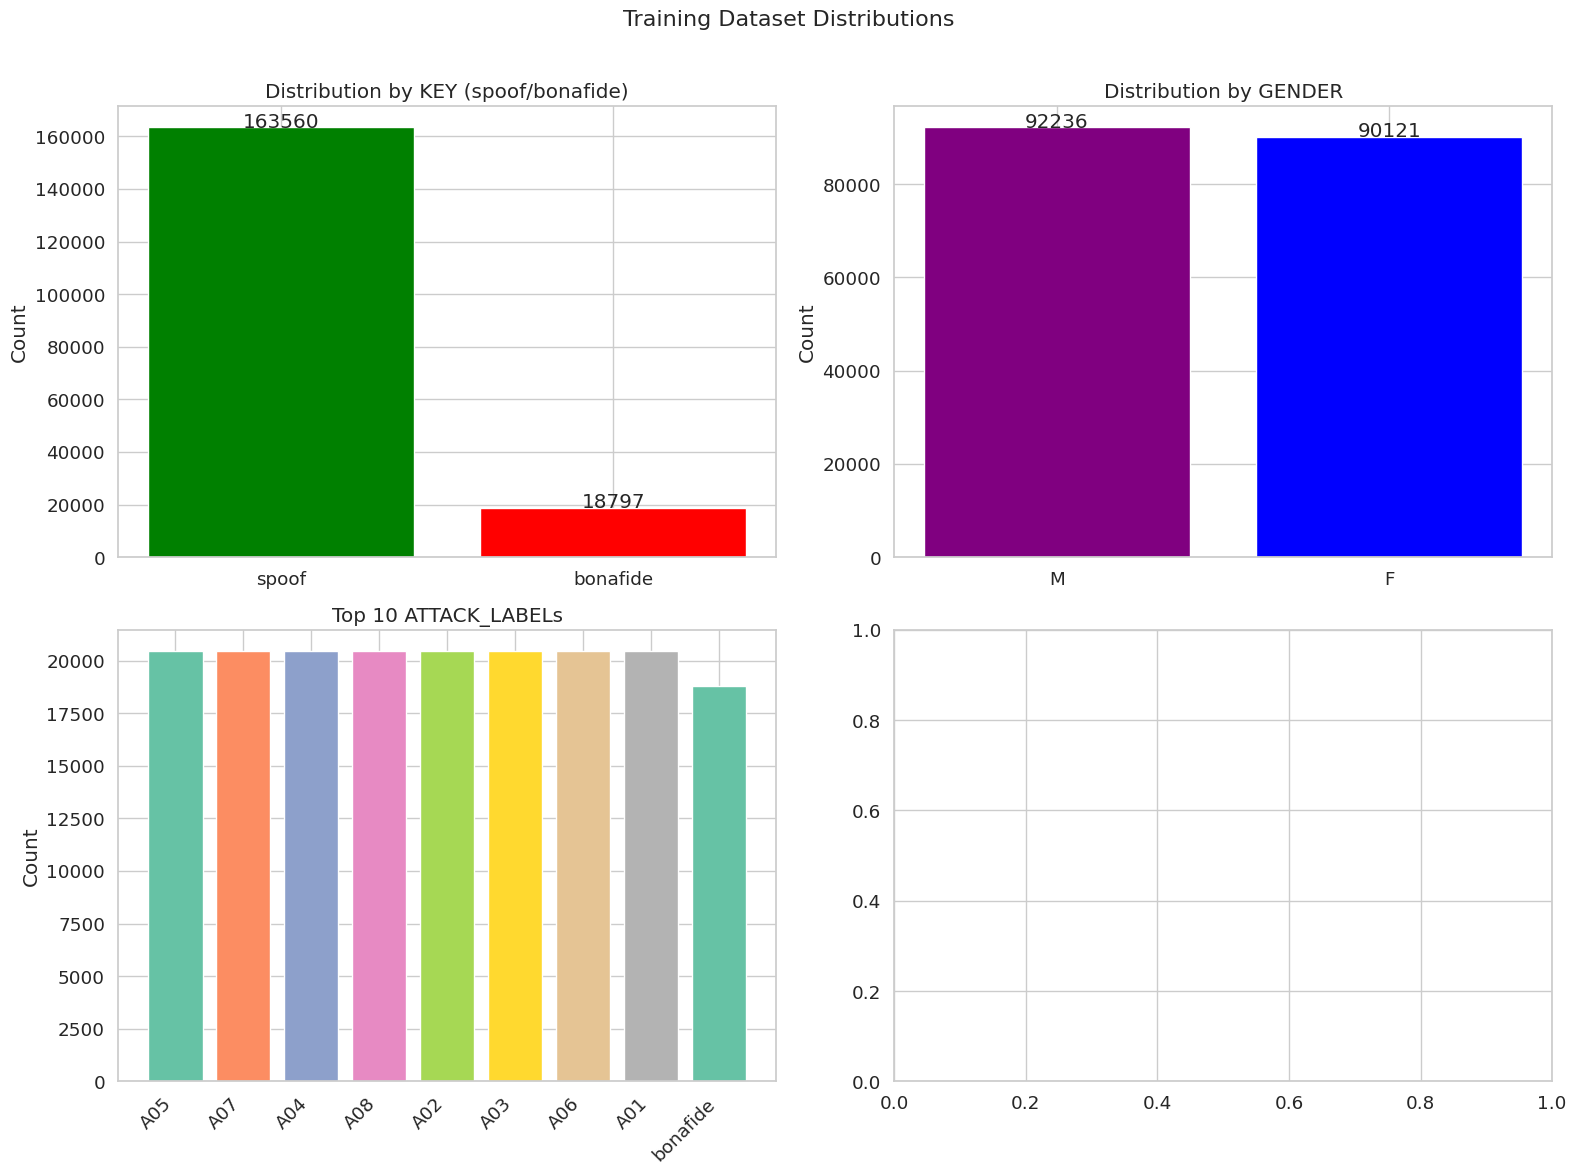

In [11]:
# Plot distributions for each dataset
plot_distributions(train_df, "Training")

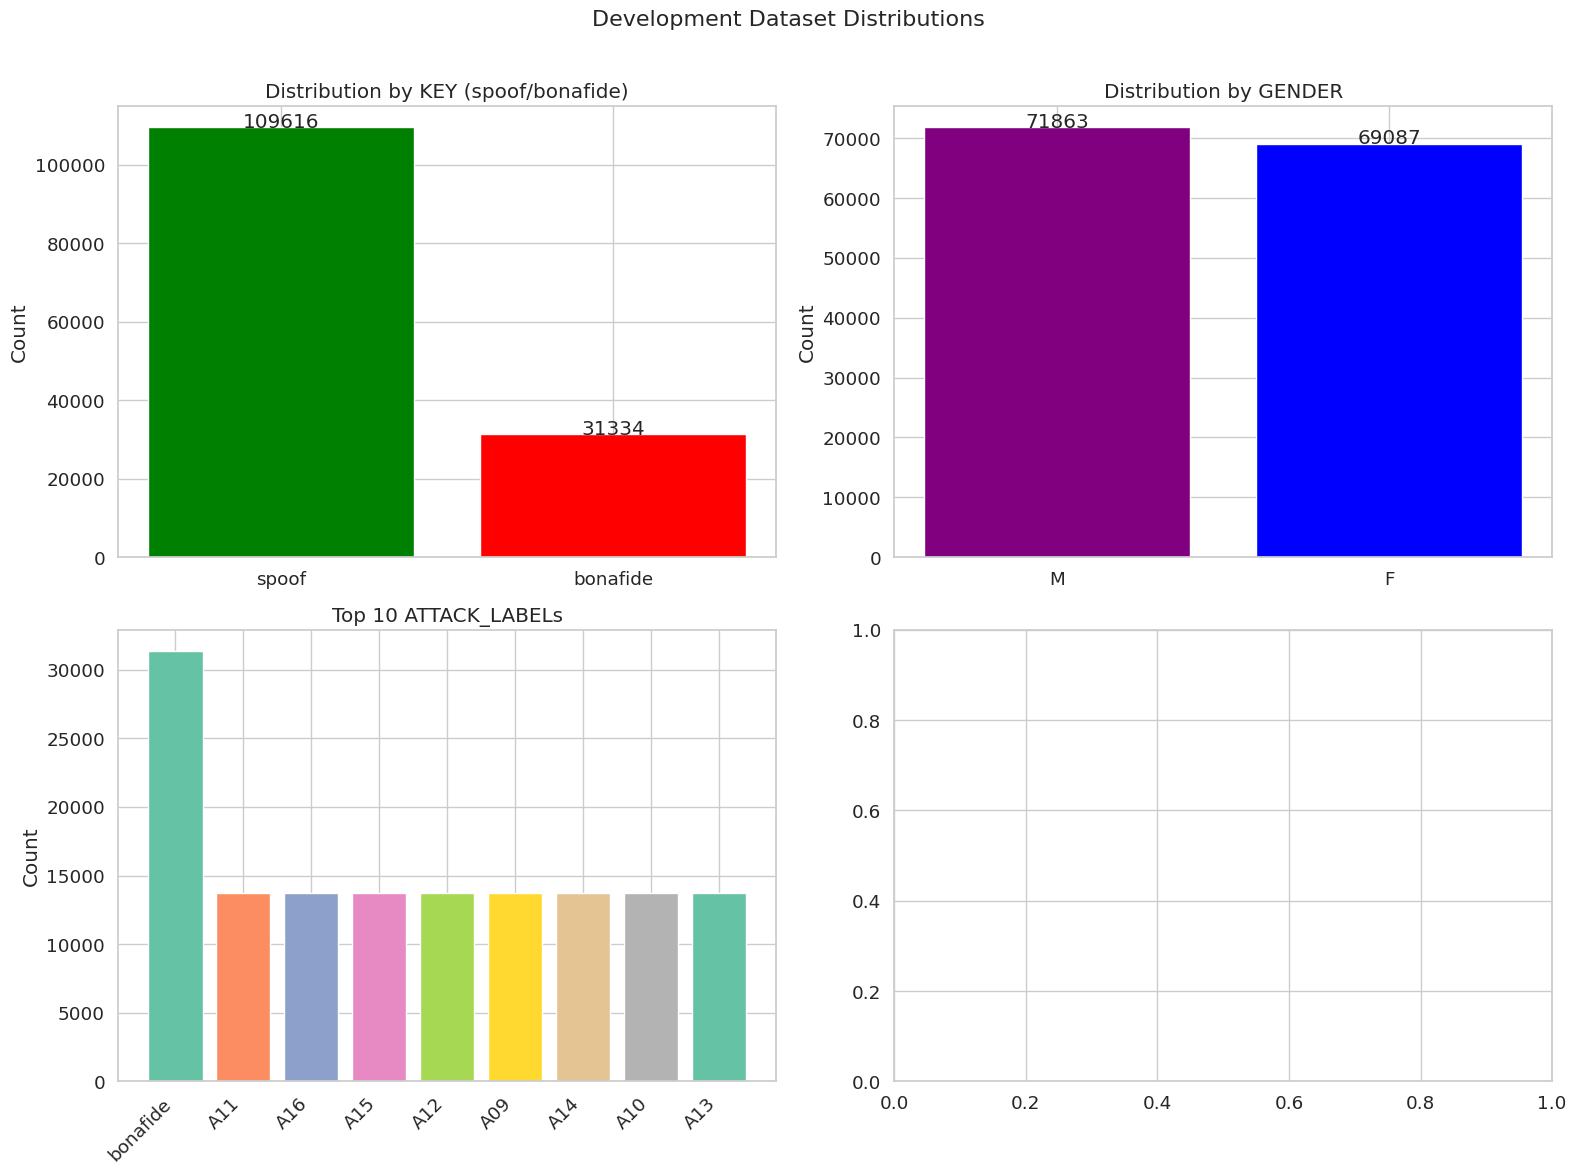

In [24]:
# Plot distributions for each dataset
plot_distributions(dev_df, "Development")

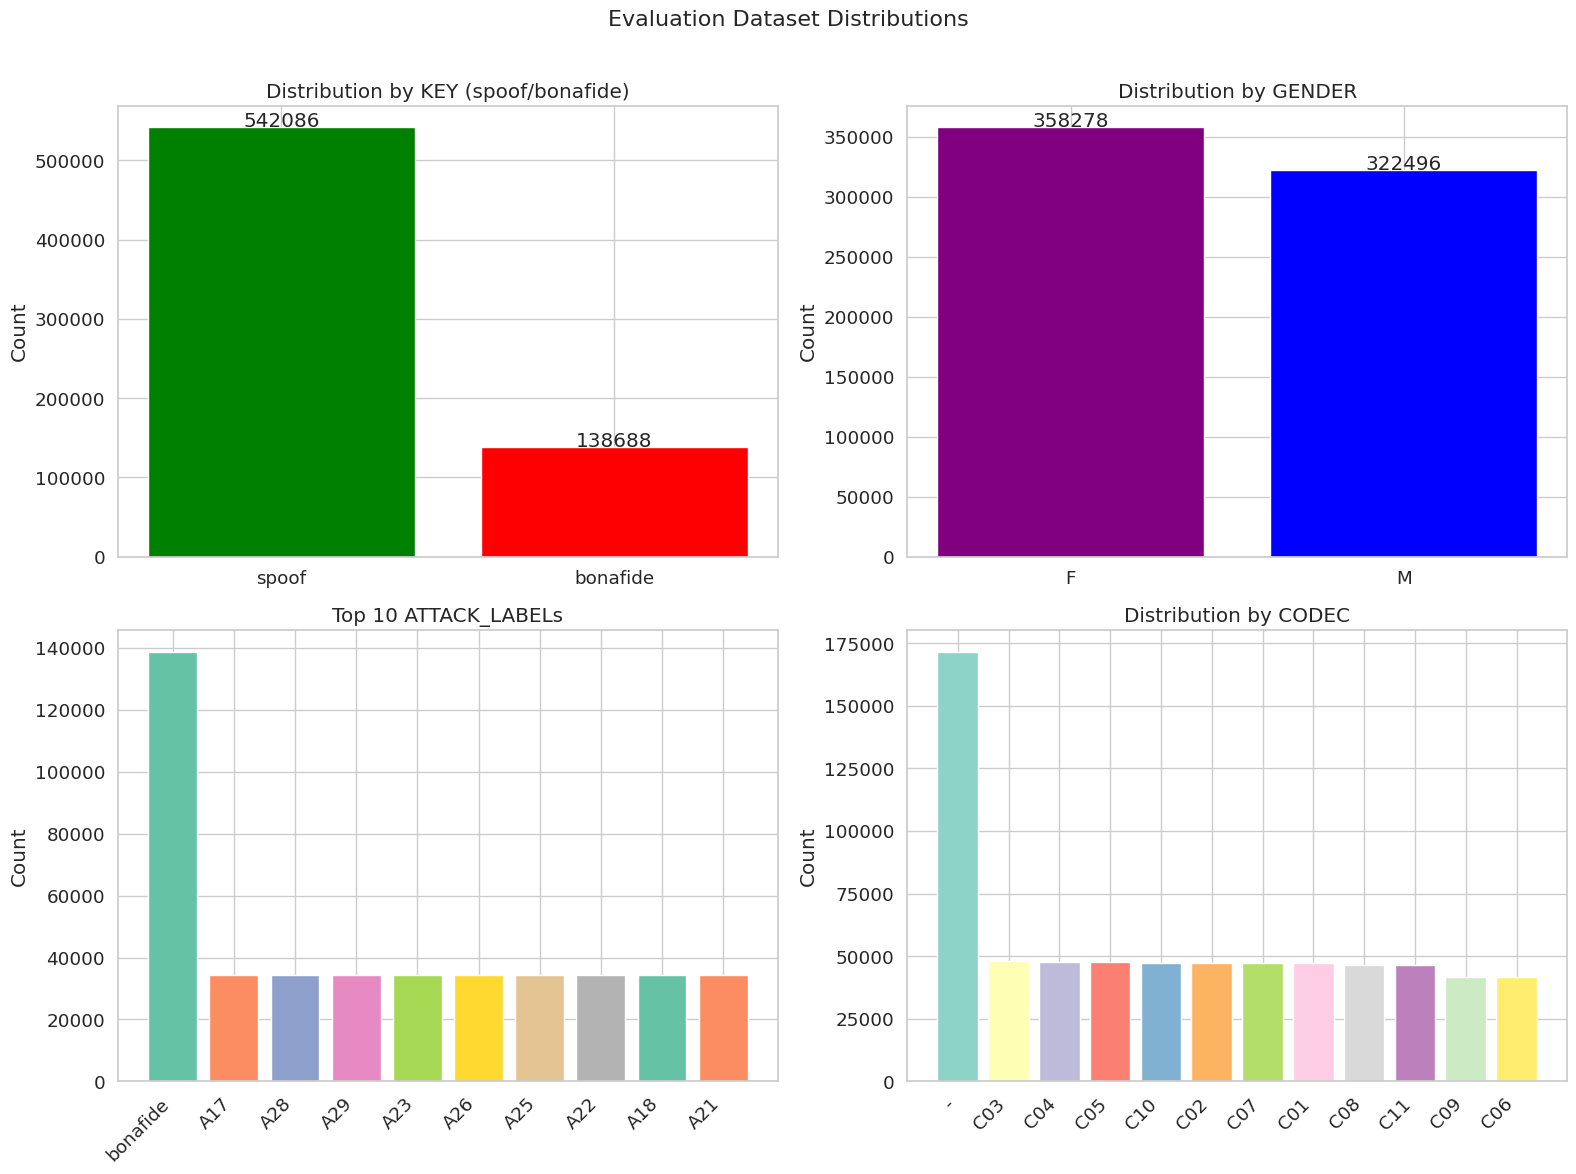

In [25]:
# Plot distributions for each dataset
plot_distributions(eval_df, "Evaluation")

Let's also create a plot to show the distribution of utterances per speaker.


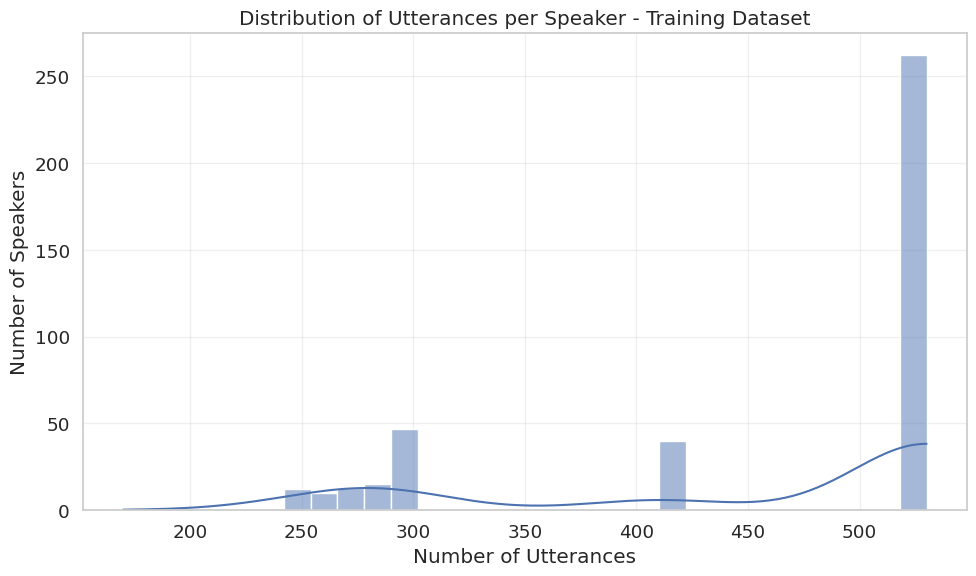

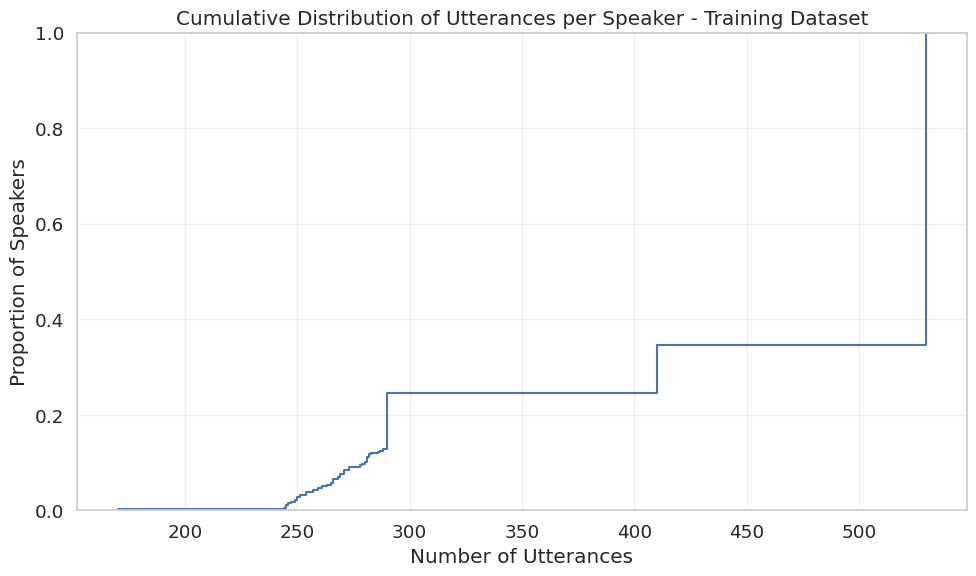

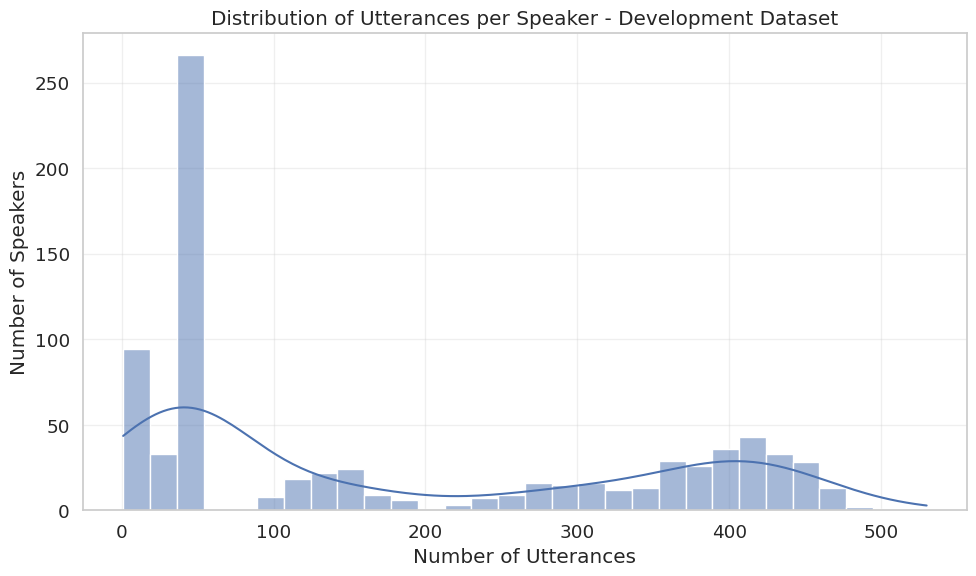

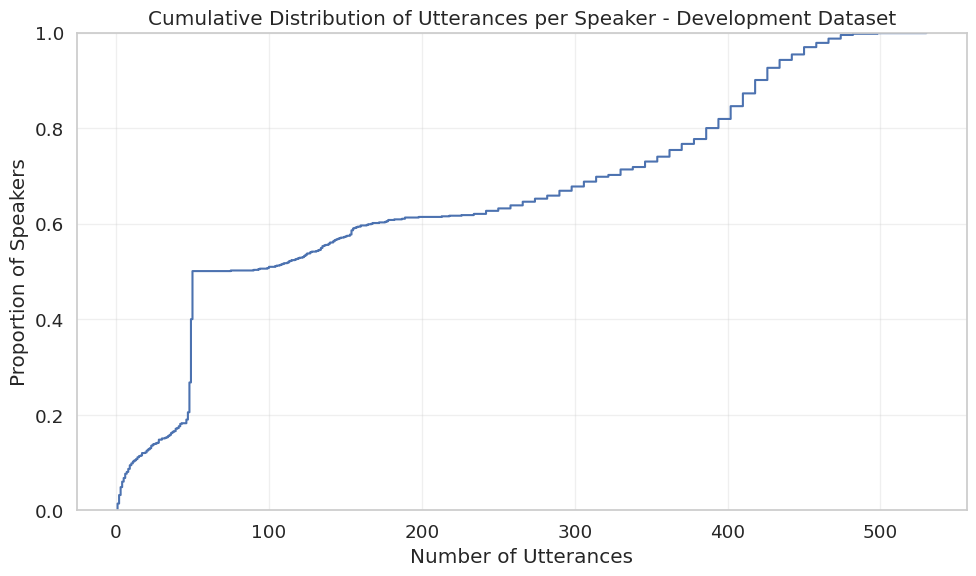

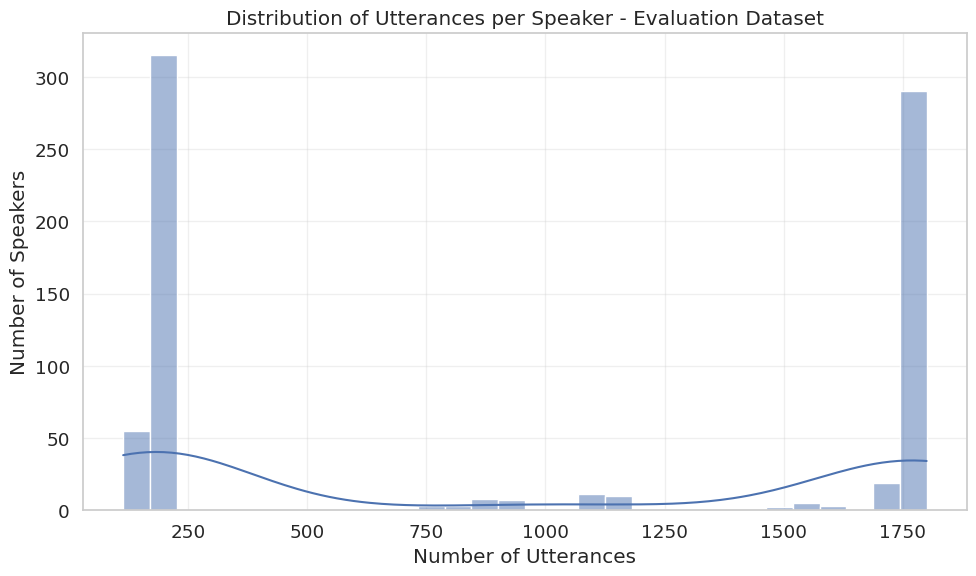

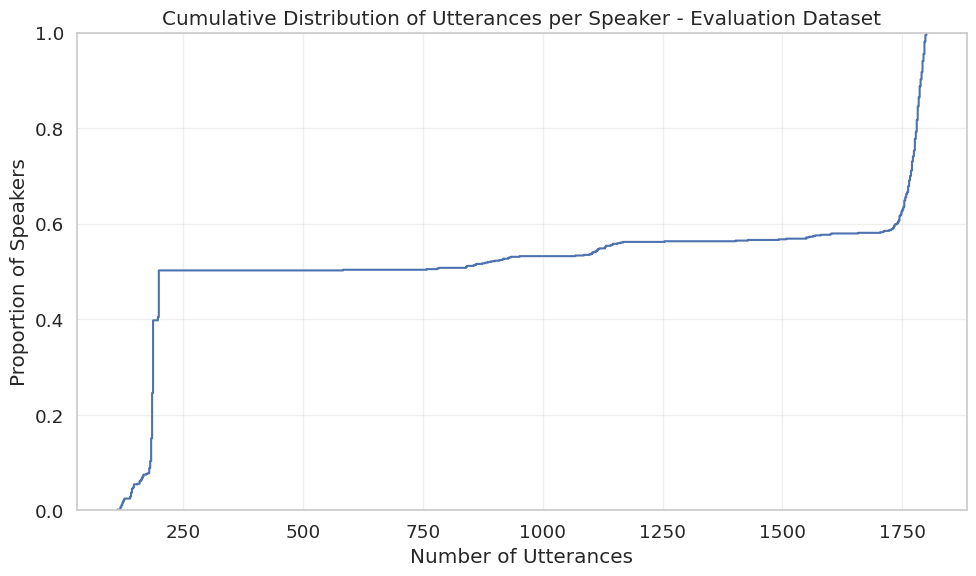

In [14]:
# Function to plot utterance distribution per speaker
def plot_utterances_per_speaker(df, name):
    if df.empty or 'SPEAKER_ID' not in df.columns:
        print(f"SPEAKER_ID column not available for {name}")
        return
    
    # Count utterances per speaker
    speaker_counts = df['SPEAKER_ID'].value_counts()
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(speaker_counts, bins=30, kde=True)
    plt.title(f'Distribution of Utterances per Speaker - {name} Dataset')
    plt.xlabel('Number of Utterances')
    plt.ylabel('Number of Speakers')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot cumulative distribution
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(speaker_counts)
    plt.title(f'Cumulative Distribution of Utterances per Speaker - {name} Dataset')
    plt.xlabel('Number of Utterances')
    plt.ylabel('Proportion of Speakers')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot utterance distributions
plot_utterances_per_speaker(train_df, "Training")
plot_utterances_per_speaker(dev_df, "Development")
plot_utterances_per_speaker(eval_df, "Evaluation")


## 4. Gender and Attack Type Analysis
Let's analyze the relationship between gender and attack type to understand if there are any patterns or biases.


<Figure size 1400x600 with 0 Axes>

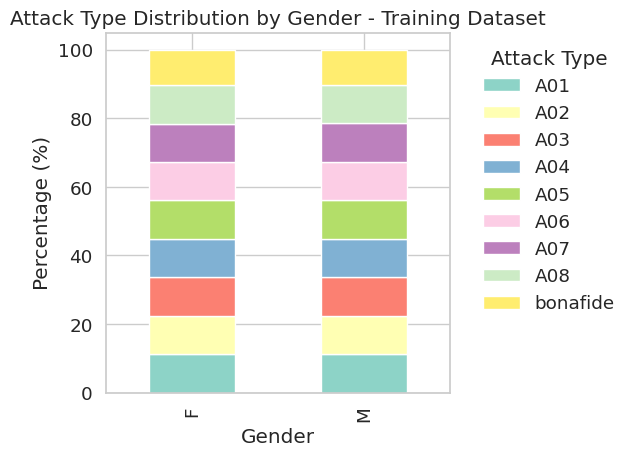


Attack type counts by gender for Training dataset:


ATTACK_LABEL,A01,A02,A03,A04,A05,A06,A07,A08,bonafide
SPEAKER_GENDER,,,,,,,,,
F,10095,10095,10095,10095,10095,10095,10095,10095,9361
M,10350,10350,10350,10350,10350,10350,10350,10350,9436


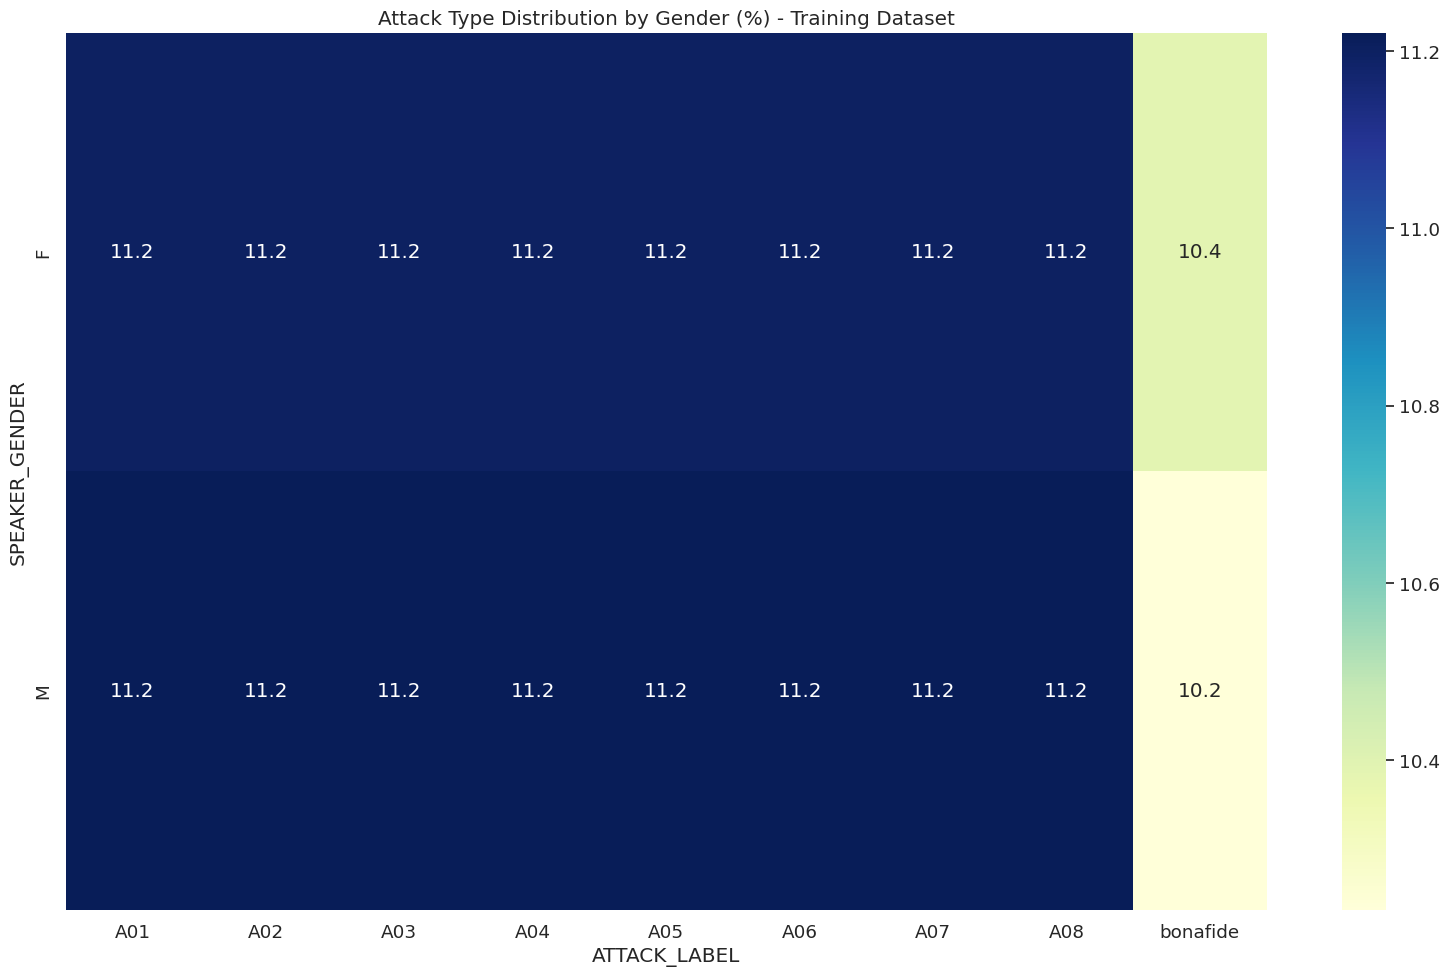

<Figure size 1400x600 with 0 Axes>

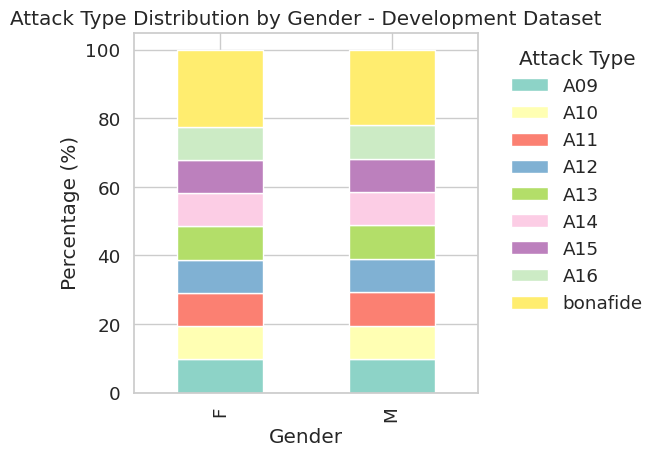


Attack type counts by gender for Development dataset:


ATTACK_LABEL,A09,A10,A11,A12,A13,A14,A15,A16,bonafide
SPEAKER_GENDER,,,,,,,,,
F,6695,6695,6695,6695,6695,6695,6695,6695,15527
M,7007,7007,7007,7007,7007,7007,7007,7007,15807


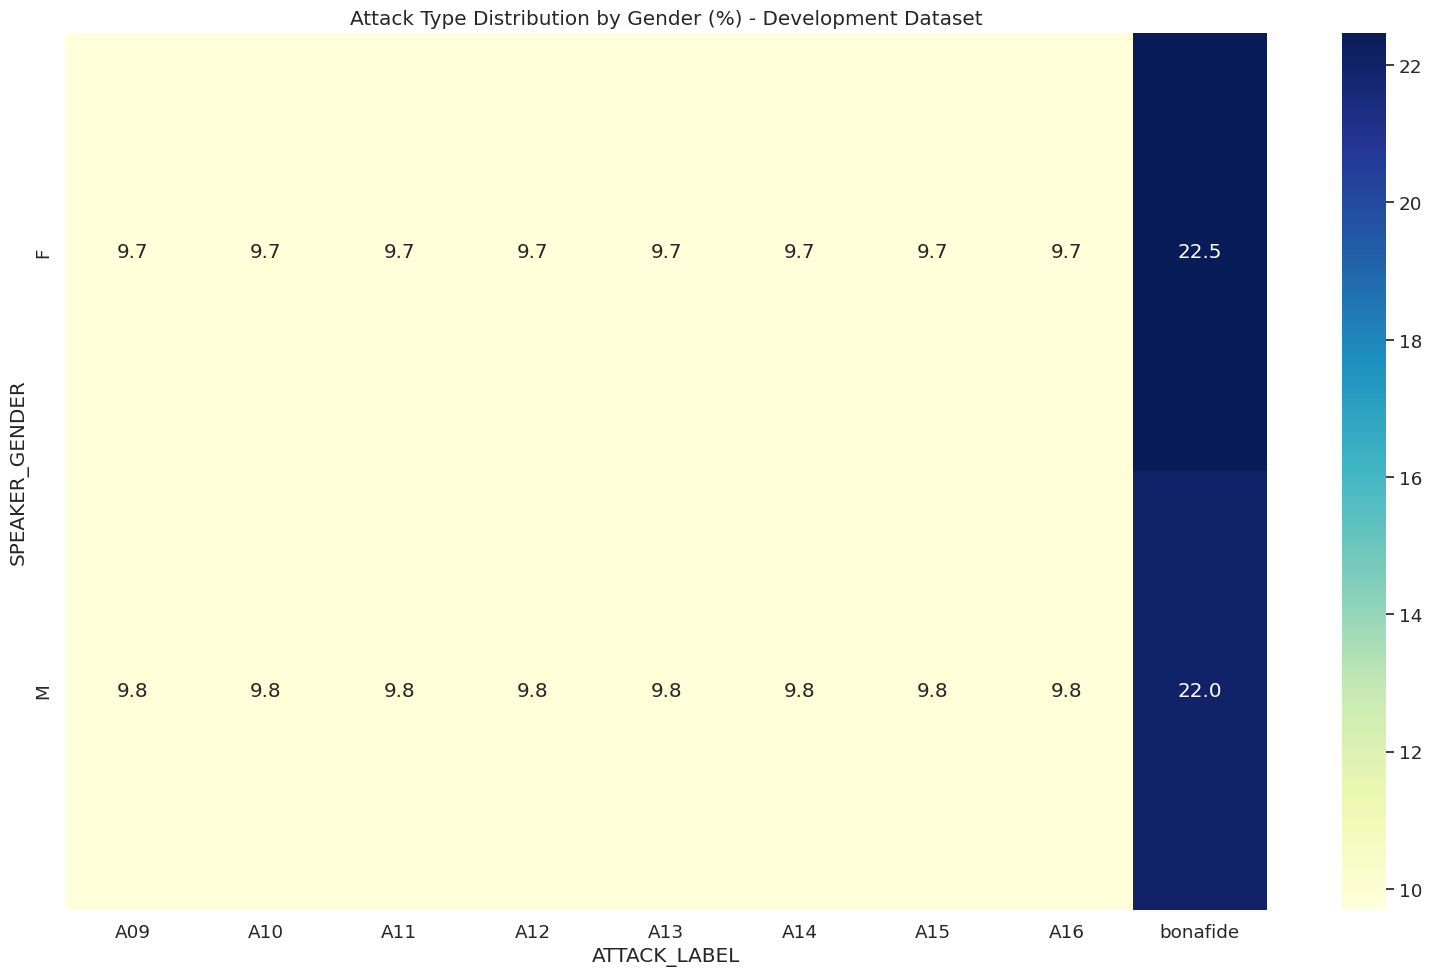

<Figure size 1400x600 with 0 Axes>

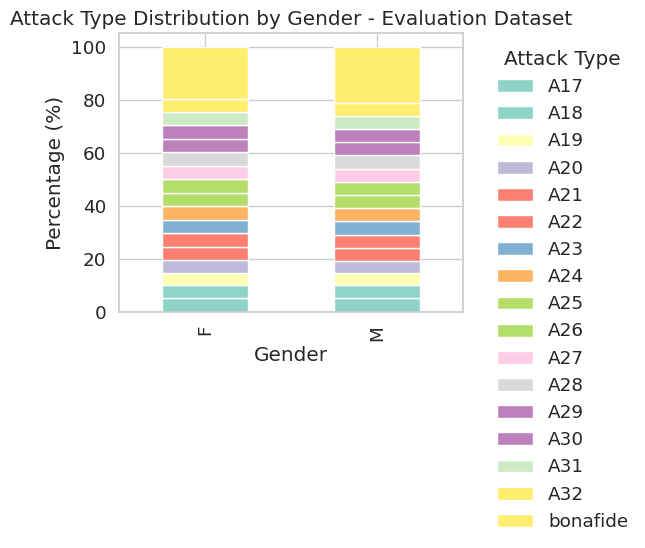


Attack type counts by gender for Evaluation dataset:


ATTACK_LABEL,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A29,A30,A31,A32,bonafide
SPEAKER_GENDER,,,,,,,,,,,,,,,,,
F,18298,18270,16356,16584,18276,18276,18288,18258,18272,18276,18160,18288,18298,18136,18040,17966,70236
M,16116,16098,14504,14860,16084,16104,16104,16080,16114,16110,16024,16126,16110,15970,15916,15724,68452


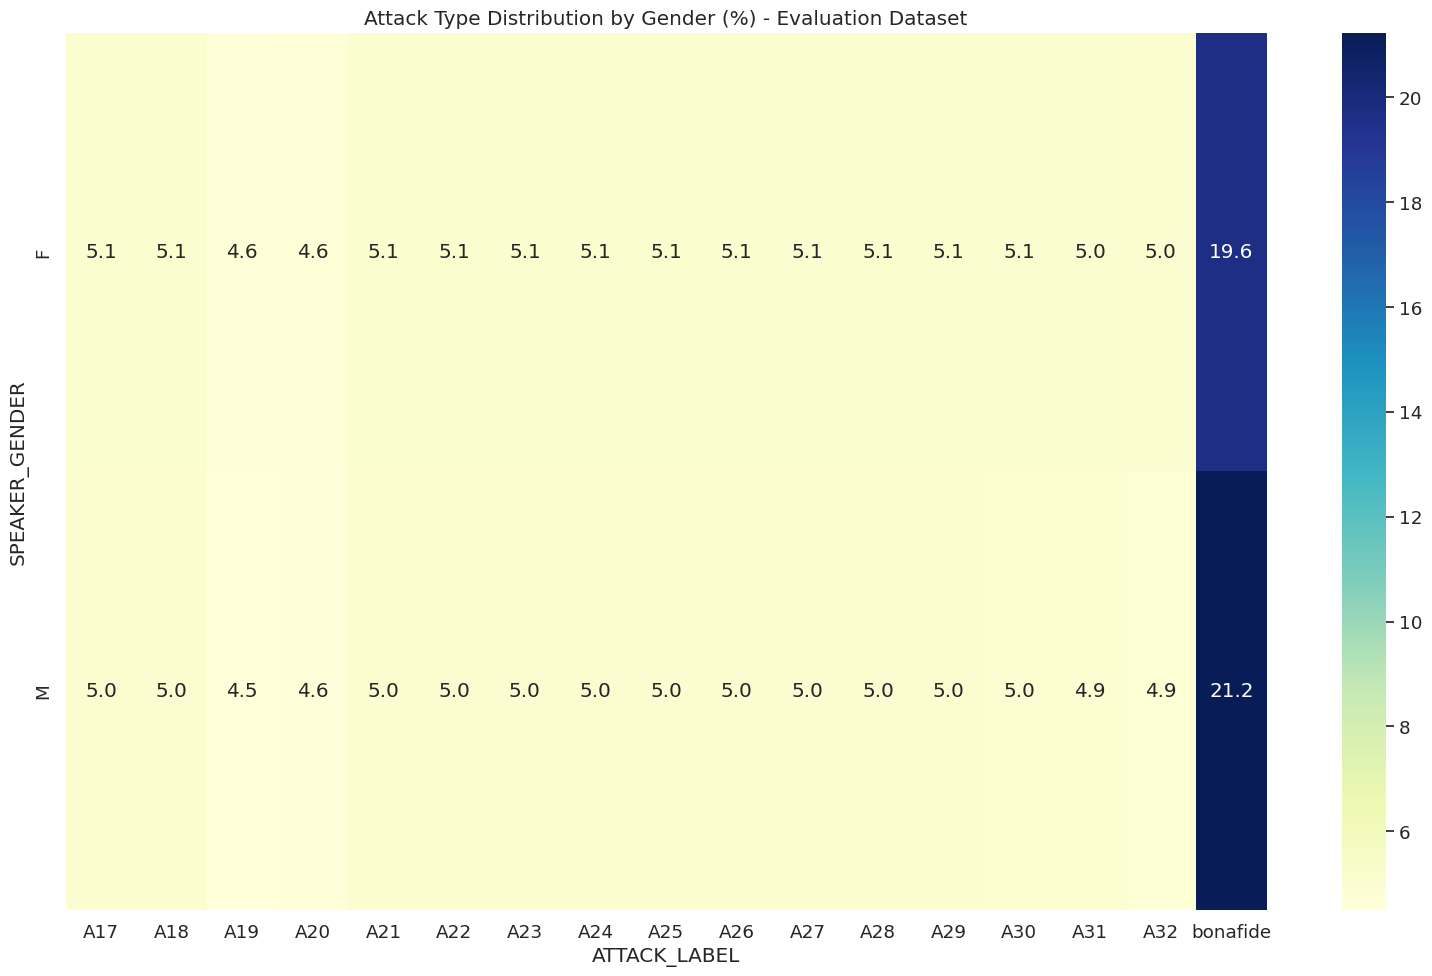

In [ ]:
# Analyze relationship between gender and attack type
def analyze_gender_attack_relationship(df, name):
    if df.empty or 'SPEAKER_GENDER' not in df.columns or 'ATTACK_LABEL' not in df.columns:
        print(f"Required columns not available for {name}")
        return
    
    # Create a crosstab between gender and attack label
    gender_attack_cross = pd.crosstab(df['SPEAKER_GENDER'], df['ATTACK_LABEL'])
    
    # Normalize by row to get percentage within each gender
    gender_attack_pct = gender_attack_cross.div(gender_attack_cross.sum(axis=1), axis=0) * 100
    
    # Plot the results
    plt.figure(figsize=(14, 6))
    gender_attack_pct.plot(kind='bar', stacked=True, colormap='Set3')
    plt.title(f'Attack Type Distribution by Gender - {name} Dataset')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Gender')
    plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Also look at the raw numbers
    print(f"\nAttack type counts by gender for {name} dataset:")
    display(gender_attack_cross)
    
    # Create a heatmap for better visualization
    plt.figure(figsize=(16, 10))
    sns.heatmap(gender_attack_pct, annot=True, cmap='YlGnBu', fmt='.1f')
    plt.title(f'Attack Type Distribution by Gender (%) - {name} Dataset')
    plt.tight_layout()
    plt.show()

# Analyze gender-attack relationship for each dataset
analyze_gender_attack_relationship(train_df, "Training")
analyze_gender_attack_relationship(dev_df, "Development")
analyze_gender_attack_relationship(eval_df, "Evaluation")

## 5. Audio Analysis

Let's load a few audio samples and analyze their properties to understand the acoustic characteristics of the dataset.

In [16]:
# Function to find and load audio files
def find_audio_files(audio_path, file_names, max_files=5):
    """Find and return paths to a sample of audio files."""
    found_files = []
    
    if not os.path.exists(audio_path):
        print(f"Warning: Audio path {audio_path} does not exist.")
        return found_files
    
    # Try to find the first max_files files
    for file_name in file_names[:min(len(file_names), max_files*10)]:
        file_path = os.path.join(audio_path, file_name)
        if os.path.exists(file_path):
            found_files.append(file_path)
            if len(found_files) >= max_files:
                break
    
    if not found_files:
        # Try a general glob search as fallback
        all_files = glob.glob(os.path.join(audio_path, "*.flac"))
        found_files = all_files[:min(len(all_files), max_files)]
    
    return found_files

# Function to analyze audio properties
def analyze_audio_properties(audio_files, name):
    if not audio_files:
        print(f"No audio files found for {name}")
        return
    
    results = []
    
    for file_path in tqdm(audio_files, desc=f"Analyzing {name} audio"):
        try:
            # Load audio file
            y, sr = librosa.load(file_path, sr=None)
            
            # Calculate properties
            duration = librosa.get_duration(y=y, sr=sr)
            rms = np.sqrt(np.mean(y**2))
            
            # Calculate spectral properties
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
            
            # Calculate zero crossing rate
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            
            results.append({
                'file': os.path.basename(file_path),
                'duration': duration,
                'sample_rate': sr,
                'rms': rms,
                'spectral_centroid': spectral_centroid,
                'spectral_bandwidth': spectral_bandwidth,
                'zero_crossing_rate': zcr
            })
        except Exception as e:
            print(f"Error analyzing {file_path}: {e}")
    
    # Convert to dataframe
    results_df = pd.DataFrame(results)
    
    print(f"\n{name} Audio Properties (Sample of {len(results)} files):")
    display(results_df)
    
    # Plot distributions
    if len(results) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle(f'{name} Audio Properties Distributions', fontsize=16)
        
        sns.histplot(results_df['duration'], kde=True, ax=axes[0, 0])
        axes[0, 0].set_title('Duration Distribution (seconds)')
        
        sns.histplot(results_df['rms'], kde=True, ax=axes[0, 1])
        axes[0, 1].set_title('RMS Energy Distribution')
        
        sns.histplot(results_df['spectral_centroid'], kde=True, ax=axes[1, 0])
        axes[1, 0].set_title('Spectral Centroid Distribution')
        
        sns.histplot(results_df['zero_crossing_rate'], kde=True, ax=axes[1, 1])
        axes[1, 1].set_title('Zero Crossing Rate Distribution')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
    
    return results_df

# Get a sample of audio files from each dataset
train_files = find_audio_files(train_audio_path, train_df['FLAC_FILE_NAME'].tolist())
dev_files = find_audio_files(dev_audio_path, dev_df['FLAC_FILE_NAME'].tolist())
eval_files = find_audio_files(eval_audio_path, eval_df['FLAC_FILE_NAME'].tolist())

# Analyze audio properties
train_audio_df = analyze_audio_properties(train_files, "Training")
dev_audio_df = analyze_audio_properties(dev_files, "Development")
eval_audio_df = analyze_audio_properties(eval_files, "Evaluation")


No audio files found for Training
No audio files found for Development
No audio files found for Evaluation


## 6. Visualize Waveforms and Spectrograms

Let's visualize waveforms and spectrograms for bonafide and spoofed audio samples to identify any visible differences.


In [17]:
# Function to find bonafide and spoofed samples
def find_bonafide_spoof_samples(df, audio_path, n_samples=2):
    if df.empty or 'KEY' not in df.columns or 'FLAC_FILE_NAME' not in df.columns:
        print("Required columns not available")
        return [], []
    
    # Get bonafide and spoofed file names
    bonafide_files = df[df['KEY'] == 'bonafide']['FLAC_FILE_NAME'].tolist()
    spoof_files = df[df['KEY'] == 'spoof']['FLAC_FILE_NAME'].tolist()
    
    # Find audio files
    bonafide_audios = find_audio_files(audio_path, bonafide_files, max_files=n_samples)
    spoof_audios = find_audio_files(audio_path, spoof_files, max_files=n_samples)
    
    return bonafide_audios, spoof_audios

# Function to visualize waveforms and spectrograms
def visualize_audio(audio_files, titles):
    if not audio_files:
        print("No audio files to visualize")
        return
    
    n_files = len(audio_files)
    fig, axes = plt.subplots(n_files, 2, figsize=(16, 5*n_files))
    
    # If only one file, make axes 2D
    if n_files == 1:
        axes = np.array([axes])
    
    for i, (file_path, title) in enumerate(zip(audio_files, titles)):
        try:
            # Load audio
            y, sr = librosa.load(file_path, sr=None)
            
            # Plot waveform
            librosa.display.waveshow(y, sr=sr, ax=axes[i, 0])
            axes[i, 0].set_title(f'{title} - Waveform')
            axes[i, 0].set_xlabel('Time (s)')
            axes[i, 0].set_ylabel('Amplitude')
            
            # Plot spectrogram
            D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
            img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=axes[i, 1])
            axes[i, 1].set_title(f'{title} - Spectrogram')
            fig.colorbar(img, ax=axes[i, 1], format='%+2.0f dB')
        except Exception as e:
            print(f"Error visualizing {file_path}: {e}")
            axes[i, 0].text(0.5, 0.5, f"Error: {e}", ha='center', va='center')
            axes[i, 1].text(0.5, 0.5, f"Error: {e}", ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

# Find bonafide and spoofed samples from the training set
train_bonafide, train_spoof = find_bonafide_spoof_samples(train_df, train_audio_path)

# Visualize training samples
if train_bonafide or train_spoof:
    all_files = train_bonafide + train_spoof
    titles = [f"Bonafide {i+1}" for i in range(len(train_bonafide))] + \
             [f"Spoofed {i+1}" for i in range(len(train_spoof))]
    visualize_audio(all_files, titles)
else:
    print("No suitable audio files found for visualization")

# Add code to play audio if in a Jupyter notebook
if train_bonafide or train_spoof:
    for i, file_path in enumerate(train_bonafide + train_spoof):
        print(f"Audio Sample {i+1}: {'Bonafide' if i < len(train_bonafide) else 'Spoofed'}")
        display(ipd.Audio(file_path))

No suitable audio files found for visualization


In [ ]:



# %% [markdown]
# ## 7. Feature Extraction and Comparison
# 
# Let's extract common audio features from the samples and compare bonafide vs. spoofed audio to identify distinguishing characteristics.

# %%
# Function to extract features from audio files
def extract_features(audio_files, labels):
    if not audio_files:
        print("No audio files to extract features from")
        return pd.DataFrame()
    
    features = []
    
    for file_path, label in tqdm(zip(audio_files, labels), total=len(audio_files), desc="Extracting features"):
        try:
            # Load audio
            y, sr = librosa.load(file_path, sr=None)
            
            # Extract features
            # MFCCs (Mel-frequency cepstral coefficients)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_means = mfccs.mean(axis=1)
            mfcc_vars = mfccs.var(axis=1)
            
            # Spectral features
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
            
            # Temporal features
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            rms = np.sqrt(np.mean(y**2))
            
            # Collect all features
            feature_dict = {
                'file': os.path.basename(file_path),
                'label': label,
                'spectral_centroid': spectral_centroid,
                'spectral_bandwidth': spectral_bandwidth,
                'spectral_rolloff': spectral_rolloff,
                'zero_crossing_rate': zcr,
                'rms_energy': rms
            }
            
            # Add MFCCs
            for i, (mean, var) in enumerate(zip(mfcc_means, mfcc_vars)):
                feature_dict[f'mfcc_{i+1}_mean'] = mean
                feature_dict[f'mfcc_{i+1}_var'] = var
            
            features.append(feature_dict)
            
        except Exception as e:
            print(f"Error extracting features from {file_path}: {e}")
    
    # Convert to dataframe
    features_df = pd.DataFrame(features)
    return features_df

# Function to collect more bonafide and spoofed samples
def collect_more_samples(df, audio_path, n_samples=10):
    bonafide_files, bonafide_labels = [], []
    spoof_files, spoof_labels = [], []
    
    if df.empty or 'KEY' not in df.columns or 'FLAC_FILE_NAME' not in df.columns:
        print("Required columns not available")
        return bonafide_files, bonafide_labels, spoof_files, spoof_labels
    
    # Get bonafide file names and their corresponding attack labels
    bonafide_data = df[df['KEY'] == 'bonafide'][['FLAC_FILE_NAME', 'ATTACK_LABEL']]
    bonafide_data = bonafide_data.sample(min(n_samples*5, len(bonafide_data)))
    
    # Get spoofed file names and their corresponding attack labels
    spoof_data = df[df['KEY'] == 'spoof'][['FLAC_FILE_NAME', 'ATTACK_LABEL']]
    spoof_data = spoof_data.sample(min(n_samples*5, len(spoof_data)))
    
    # Find audio files
    for _, row in bonafide_data.iterrows():
        file_path = os.path.join(audio_path, row['FLAC_FILE_NAME'])
        if os.path.exists(file_path):
            bonafide_files.append(file_path)
            bonafide_labels.append('bonafide')
            if len(bonafide_files) >= n_samples:
                break
    
    for _, row in spoof_data.iterrows():
        file_path = os.path.join(audio_path, row['FLAC_FILE_NAME'])
        if os.path.exists(file_path):
            spoof_files.append(file_path)
            spoof_labels.append(f"spoof_{row['ATTACK_LABEL']}")
            if len(spoof_files) >= n_samples:
                break
    
    return bonafide_files, bonafide_labels, spoof_files, spoof_labels

# Collect more samples
train_bonafide_files, train_bonafide_labels, train_spoof_files, train_spoof_labels = collect_more_samples(train_df, train_audio_path)

# Combine files and labels
all_files = train_bonafide_files + train_spoof_files
all_labels = train_bonafide_labels + train_spoof_labels

# Extract features
features_df = extract_features(all_files, all_labels)

# Display extracted features
if not features_df.empty:
    print("\nExtracted features:")
    display(features_df.head())
    
    # Visualize feature distributions by label
    plt.figure(figsize=(16, 10))
    
    # Select numeric columns
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    
    # Create a subplot for each feature
    n_features = min(len(numeric_cols), 6)  # Limit to 6 features for clarity
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(numeric_cols[:n_features]):
        sns.boxplot(x='label', y=feature, data=features_df, ax=axes[i])
        axes[i].set_title(f'{feature} by Label')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Use PCA to visualize the feature space
    if len(features_df) > 3:
        # Select only numeric columns for PCA
        X = features_df.select_dtypes(include=[np.number]).copy()
        
        # Standardize features
        X = (X - X.mean()) / X.std()
        
        # Apply PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        # Create PCA dataframe
        pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        pca_df['Label'] = features_df['label']
        
        # Plot PCA
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x='PC1', y='PC2', hue='Label', data=pca_df, s=100, alpha=0.7)
        plt.title('PCA of Audio Features (Bonafide vs. Spoofed)')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # Apply t-SNE for better visualization
        try:
            tsne = TSNE(n_components=2, random_state=42)
            X_tsne = tsne.fit_transform(X)
            
            # Create t-SNE dataframe
            tsne_df = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
            tsne_df['Label'] = features_df['label']
            
            # Plot t-SNE
            plt.figure(figsize=(12, 8))
            sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='Label', data=tsne_df, s=100, alpha=0.7)
            plt.title('t-SNE of Audio Features (Bonafide vs. Spoofed)')
            plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error running t-SNE: {e}")
else:
    print("No features extracted. Check if audio files were found.")

# %% [markdown]
# ## 8. Analyze Attack Types
# 
# Let's analyze the different attack types present in the dataset and their distribution.

# %%
# Function to analyze attack types
def analyze_attack_types(df, name):
    if df.empty or 'ATTACK_LABEL' not in df.columns:
        print(f"ATTACK_LABEL column not available for {name}")
        return
    
    # Count attack types
    attack_counts = df['ATTACK_LABEL'].value_counts()
    
    print(f"\nAttack types in {name} dataset:")
    for attack, count in attack_counts.items():
        percentage = count / len(df) * 100
        print(f"  {attack}: {count} ({percentage:.2f}%)")
    
    # Plot attack distribution
    plt.figure(figsize=(12, 8))
    ax = attack_counts.plot(kind='bar', colormap='viridis')
    plt.title(f'Attack Type Distribution - {name} Dataset')
    plt.ylabel('Count')
    plt.xlabel('Attack Type')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add count labels on top of bars
    for i, v in enumerate(attack_counts):
        ax.text(i, v + 0.1, str(v), ha='center')
    
    plt.show()
    
    # If we have gender information, analyze attacks by gender
    if 'SPEAKER_GENDER' in df.columns:
        # Create a crosstab
        gender_attack = pd.crosstab(df['ATTACK_LABEL'], df['SPEAKER_GENDER'])
        
        # Plot stacked bar chart
        plt.figure(figsize=(12, 8))
        gender_attack.plot(kind='bar', stacked=True)
        plt.title(f'Attack Types by Gender - {name} Dataset')
        plt.ylabel('Count')
        plt.xlabel('Attack Type')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Gender')
        plt.tight_layout()
        plt.show()

# Run the analysis
analyze_attack_types(train_df, "Training")
analyze_attack_types(dev_df, "Development")
analyze_attack_types(eval_df, "Evaluation")

# %% [markdown]
# ## 9. Codec Analysis
# 
# Let's examine the codecs used in the dataset and their impact on the audio quality and spoofing detection.

# %%
# Function to analyze codecs
def analyze_codecs(df, name):
    if df.empty or 'CODEC' not in df.columns:
        print(f"CODEC column not available for {name}")
        return
    
    # Count codecs
    codec_counts = df['CODEC'].value_counts()
    
    print(f"\nCodecs in {name} dataset:")
    for codec, count in codec_counts.items():
        percentage = count / len(df) * 100
        print(f"  {codec}: {count} ({percentage:.2f}%)")
    
    # Plot codec distribution
    plt.figure(figsize=(10, 6))
    ax = codec_counts.plot(kind='bar', colormap='tab10')
    plt.title(f'Codec Distribution - {name} Dataset')
    plt.ylabel('Count')
    plt.xlabel('Codec')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add count labels on top of bars
    for i, v in enumerate(codec_counts):
        ax.text(i, v + 0.1, str(v), ha='center')
    
    plt.show()
    
    # If we have KEY information, analyze relationship between codec and spoof/bonafide
    if 'KEY' in df.columns:
        # Create a crosstab
        codec_key = pd.crosstab(df['CODEC'], df['KEY'], normalize='index') * 100
        
        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(codec_key, annot=True, cmap='YlGnBu', fmt='.1f')
        plt.title(f'Relationship Between Codec and Key (%) - {name} Dataset')
        plt.ylabel('Codec')
        plt.xlabel('Key')
        plt.tight_layout()
        plt.show()
    
    # If we have CODEC_Q information, analyze relationship between codec and quality
    if 'CODEC_Q' in df.columns:
        # Create a crosstab
        codec_quality = pd.crosstab(df['CODEC'], df['CODEC_Q'])
        
        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(codec_quality, annot=True, cmap='rocket_r', fmt='d')
        plt.title(f'Relationship Between Codec and Quality - {name} Dataset')
        plt.ylabel('Codec')
        plt.xlabel('Codec Quality')
        plt.tight_layout()
        plt.show()
    
    # If we have ATTACK_LABEL information, analyze relationship between codec and attack type
    if 'ATTACK_LABEL' in df.columns:
        # Get top attack types to avoid overcrowding
        top_attacks = df['ATTACK_LABEL'].value_counts().nlargest(10).index
        
        # Create a crosstab with top attack types
        codec_attack = pd.crosstab(
            df['CODEC'], 
            df['ATTACK_LABEL'].apply(lambda x: x if x in top_attacks else 'Other')
        )
        
        # Calculate percentages
        codec_attack_pct = codec_attack.div(codec_attack.sum(axis=1), axis=0) * 100
        
        # Plot heatmap
        plt.figure(figsize=(14, 10))
        sns.heatmap(codec_attack_pct, annot=True, cmap='YlGnBu', fmt='.1f')
        plt.title(f'Attack Types by Codec (%) - {name} Dataset')
        plt.ylabel('Codec')
        plt.xlabel('Attack Type')
        plt.tight_layout()
        plt.show()

# Run the analysis
analyze_codecs(train_df, "Training")
analyze_codecs(dev_df, "Development")
analyze_codecs(eval_df, "Evaluation")

# %% [markdown]
# ## 10. Analyzing Attack Tags
# 
# Let's examine the ATTACK_TAG column and understand its distribution and relationship with other variables. Attack tags represent different conditions or configurations used in generating the spoofed audio.

# %%
# Function to analyze attack tags
def analyze_attack_tags(df, name):
    if df.empty or 'ATTACK_TAG' not in df.columns:
        print(f"ATTACK_TAG column not available for {name}")
        return
    
    # Count attack tags
    tag_counts = df['ATTACK_TAG'].value_counts()
    
    print(f"\nAttack tags in {name} dataset:")
    for tag, count in tag_counts.items():
        percentage = count / len(df) * 100
        print(f"  {tag}: {count} ({percentage:.2f}%)")
    
    # Plot attack tag distribution
    plt.figure(figsize=(10, 6))
    ax = tag_counts.plot(kind='bar', colormap='Set3')
    plt.title(f'Attack Tag Distribution - {name} Dataset')
    plt.ylabel('Count')
    plt.xlabel('Attack Tag')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add count labels on top of bars
    for i, v in enumerate(tag_counts):
        ax.text(i, v + 0.1, str(v), ha='center')
    
    plt.show()
    
    # Analyze relationship between attack tag and attack label
    if 'ATTACK_LABEL' in df.columns:
        # Create a crosstab
        tag_label = pd.crosstab(df['ATTACK_TAG'], df['ATTACK_LABEL'])
        
        # Get the top 10 attack labels to avoid overcrowding the plot
        top_labels = df['ATTACK_LABEL'].value_counts().nlargest(10).index
        tag_label_filtered = tag_label[top_labels]
        
        # Plot heatmap
        plt.figure(figsize=(14, 10))
        sns.heatmap(tag_label_filtered, annot=True, cmap='YlGnBu', fmt='d')
        plt.title(f'Relationship Between Attack Tag and Top 10 Attack Labels - {name} Dataset')
        plt.ylabel('Attack Tag')
        plt.xlabel('Attack Label')
        plt.tight_layout()
        plt.show()
        
        # Calculate percentages
        tag_label_pct = tag_label_filtered.div(tag_label_filtered.sum(axis=1), axis=0) * 100
        
        # Plot percentage heatmap
        plt.figure(figsize=(14, 10))
        sns.heatmap(tag_label_pct, annot=True, cmap='YlGnBu', fmt='.1f')
        plt.title(f'Relationship Between Attack Tag and Attack Labels (%) - {name} Dataset')
        plt.ylabel('Attack Tag')
        plt.xlabel('Attack Label')
        plt.tight_layout()
        plt.show()

# Run the analysis
analyze_attack_tags(train_df, "Training")
analyze_attack_tags(dev_df, "Development")
analyze_attack_tags(eval_df, "Evaluation")

# %% [markdown]
# ## 11. Duration and Quality Metrics Analysis
# 
# Let's analyze the duration of audio files and various quality metrics to see if there are differences between bonafide and spoofed audio. This analysis can help identify potential distinguishing factors for spoofing detection.

# %%
# Function to analyze duration and quality
def analyze_duration_quality(audio_files, labels):
    if not audio_files:
        print("No audio files to analyze")
        return pd.DataFrame()
    
    results = []
    
    for file_path, label in tqdm(zip(audio_files, labels), total=len(audio_files), desc="Analyzing audio quality"):
        try:
            # Load audio
            y, sr = librosa.load(file_path, sr=None)
            
            # Calculate duration
            duration = librosa.get_duration(y=y, sr=sr)
            
            # Calculate overall RMS energy
            rms = np.sqrt(np.mean(y**2))
            
            # Calculate signal-to-noise ratio (SNR) estimate
            # This is a simplistic approach - quietest 5% frames as noise estimate
            frame_length = int(sr * 0.025)  # 25ms frames
            hop_length = int(sr * 0.01)     # 10ms hop
            
            y_frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
            frame_rms = np.sqrt(np.mean(y_frames**2, axis=0))
            frame_rms_sorted = np.sort(frame_rms)
            noise_rms = np.mean(frame_rms_sorted[:int(len(frame_rms_sorted) * 0.05)])
            if noise_rms > 0:
                snr = 20 * np.log10(rms / noise_rms)
            else:
                snr = 100  # Arbitrarily high value if no noise detected
            
            # Calculate average zero-crossing rate (indicating noisiness/smoothness)
            zcr = librosa.feature.zero_crossing_rate(y).mean()
            
            # Measure amplitude dynamics
            dynamic_range = np.max(np.abs(y)) - np.min(np.abs(y))
            
            # Calculate spectral bandwidth (indicating frequency spread)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
            
            # Calculate spectral centroid (indicating "brightness")
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
            
            results.append({
                'file': os.path.basename(file_path),
                'label': label,
                'duration': duration,
                'rms_energy': rms,
                'snr_estimate': snr,
                'zero_crossing_rate': zcr,
                'dynamic_range': dynamic_range,
                'spectral_bandwidth': spec_bw,
                'spectral_centroid': spec_cent
            })
            
        except Exception as e:
            print(f"Error analyzing {file_path}: {e}")
    
    # Convert to dataframe
    results_df = pd.DataFrame(results)
    
    # Simplify labels for visualization
    if 'label' in results_df.columns:
        results_df['type'] = results_df['label'].apply(
            lambda x: 'bonafide' if x == 'bonafide' else 'spoof'
        )
    
    return results_df

# Get more diverse samples for analysis
train_more_bonafide, train_more_bonafide_labels, train_more_spoof, train_more_spoof_labels = collect_more_samples(train_df, train_audio_path, n_samples=15)

# Combine the files and labels
all_quality_files = train_more_bonafide + train_more_spoof
all_quality_labels = train_more_bonafide_labels + train_more_spoof_labels

# Analyze duration and quality metrics
quality_df = analyze_duration_quality(all_quality_files, all_quality_labels)

if not quality_df.empty:
    print("\nDuration and quality metrics:")
    display(quality_df.head())
    
    # Create comparison plots
    metrics = ['duration', 'rms_energy', 'snr_estimate', 'zero_crossing_rate', 
               'dynamic_range', 'spectral_bandwidth', 'spectral_centroid']
    
    # Create boxplots for comparison
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    
    for i, metric in enumerate(metrics):
        if metric in quality_df.columns:
            sns.boxplot(x='type', y=metric, data=quality_df, ax=axes[i], 
                       palette={'bonafide': 'green', 'spoof': 'red'})
            axes[i].set_title(f'{metric} Comparison: Bonafide vs. Spoofed')
            axes[i].set_xlabel('')
    
    plt.tight_layout()
    plt.show()
    
    # Create a correlation matrix
    plt.figure(figsize=(12, 10))
    corr_matrix = quality_df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Matrix of Audio Quality Metrics')
    plt.tight_layout()
    plt.show()
    
    # Create violin plots for key metrics
    key_metrics = ['snr_estimate', 'zero_crossing_rate', 'spectral_centroid']
    
    fig, axes = plt.subplots(1, len(key_metrics), figsize=(16, 6))
    
    for i, metric in enumerate(key_metrics):
        if metric in quality_df.columns:
            sns.violinplot(x='type', y=metric, data=quality_df, ax=axes[i],
                          palette={'bonafide': 'green', 'spoof': 'red'})
            axes[i].set_title(f'{metric} Distribution')
            axes[i].set_xlabel('')
    
    plt.tight_layout()
    plt.show()
else:
    print("No quality metrics could be calculated. Check if audio files were found.")

# %% [markdown]
# ## 12. Speaker Analysis
# 
# Let's analyze the distribution of speakers in the dataset and how spoofing attacks are distributed across speakers. This can help identify potential speaker-dependent biases in the dataset.

# %%
# Function to analyze speaker distribution
def analyze_speakers(df, name):
    if df.empty or 'SPEAKER_ID' not in df.columns:
        print(f"SPEAKER_ID column not available for {name}")
        return
    
    # Count utterances per speaker
    speaker_counts = df['SPEAKER_ID'].value_counts()
    
    print(f"\nSpeaker distribution in {name} dataset:")
    print(f"- Total speakers: {len(speaker_counts)}")
    print(f"- Average utterances per speaker: {speaker_counts.mean():.2f}")
    print(f"- Min utterances per speaker: {speaker_counts.min()}")
    print(f"- Max utterances per speaker: {speaker_counts.max()}")
    print(f"- Median utterances per speaker: {speaker_counts.median()}")
    
    # Plot distribution of utterances per speaker
    plt.figure(figsize=(12, 6))
    sns.histplot(speaker_counts, bins=30, kde=True)
    plt.title(f'Distribution of Utterances per Speaker - {name} Dataset')
    plt.xlabel('Number of Utterances')
    plt.ylabel('Number of Speakers')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Analyze spoofing attacks per speaker
    if 'KEY' in df.columns:
        # Create a crosstab of speakers and attack status
        speaker_key = pd.crosstab(df['SPEAKER_ID'], df['KEY'])
        
        # Calculate percentage of spoofed utterances per speaker
        speaker_key['total'] = speaker_key.sum(axis=1)
        speaker_key['spoof_pct'] = speaker_key['spoof'] / speaker_key['total'] * 100
        
        # Plot distribution of spoofing percentages
        plt.figure(figsize=(12, 6))
        sns.histplot(speaker_key['spoof_pct'], bins=20, kde=True)
        plt.title(f'Distribution of Spoofing Percentages per Speaker - {name} Dataset')
        plt.xlabel('Percentage of Spoofed Utterances (%)')
        plt.ylabel('Number of Speakers')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Find speakers with highest/lowest spoofing percentages
        print("\nSpeakers with highest spoofing percentages:")
        high_spoof = speaker_key.nlargest(5, 'spoof_pct')
        for speaker, row in high_spoof.iterrows():
            print(f"  Speaker {speaker}: {row['spoof_pct']:.2f}% spoofed ({row['spoof']} out of {row['total']} utterances)")
        
        print("\nSpeakers with lowest spoofing percentages:")
        low_spoof = speaker_key.nsmallest(5, 'spoof_pct')
        for speaker, row in low_spoof.iterrows():
            print(f"  Speaker {speaker}: {row['spoof_pct']:.2f}% spoofed ({row['spoof']} out of {row['total']} utterances)")
        
        # Analyze gender balance among speakers if gender info is available
        if 'SPEAKER_GENDER' in df.columns:
            # Get gender for each speaker
            speaker_gender = df[['SPEAKER_ID', 'SPEAKER_GENDER']].drop_duplicates().set_index('SPEAKER_ID')
            
            # Join with spoofing percentages
            speaker_analysis = speaker_key.join(speaker_gender)
            
            # Plot spoofing percentage by gender
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='SPEAKER_GENDER', y='spoof_pct', data=speaker_analysis)
            plt.title(f'Spoofing Percentage by Speaker Gender - {name} Dataset')
            plt.xlabel('Gender')
            plt.ylabel('Percentage of Spoofed Utterances (%)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Print gender statistics
            print("\nSpoofing percentage by gender:")
            gender_stats = speaker_analysis.groupby('SPEAKER_GENDER')['spoof_pct'].agg(['mean', 'min', 'max', 'std'])
            display(gender_stats)

# Run the analysis
analyze_speakers(train_df, "Training")
analyze_speakers(dev_df, "Development")
analyze_speakers(eval_df, "Evaluation")

# %% [markdown]
# ## 13. Advanced Visualization of Feature Relationships
# 
# Let's create more sophisticated visualizations to understand the relationships between different audio features and their effectiveness in distinguishing between bonafide and spoofed audio.

# %%
# Function to create interactive feature visualizations
def create_interactive_plots(features_df):
    if features_df.empty:
        print("No features available for visualization")
        return
    
    # Simplify labels for visualization
    if 'label' in features_df.columns:
        features_df['type'] = features_df['label'].apply(
            lambda x: 'bonafide' if x == 'bonafide' else 'spoof'
        )
    
    # Select only numeric columns for analysis
    numeric_df = features_df.select_dtypes(include=[np.number]).copy()
    
    # Create correlation heatmap
    corr_matrix = numeric_df.corr()
    
    # Create a heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Create pairplots for selected features
    if len(numeric_df.columns) > 3:
        # Select a subset of most important features
        top_features = ['spectral_centroid', 'spectral_bandwidth', 'zero_crossing_rate', 'rms_energy']
        top_features = [f for f in top_features if f in numeric_df.columns]
        
        if len(top_features) >= 3:
            pairs_df = numeric_df[top_features].copy()
            pairs_df['type'] = features_df['type'] if 'type' in features_df.columns else 'Unknown'
            
            # Create pairplot
            plt.figure(figsize=(12, 10))
            sns.pairplot(pairs_df, hue='type', markers=['o', 's'], 
                         palette={'bonafide': 'green', 'spoof': 'red'}, 
                         plot_kws={'alpha': 0.7, 's': 80})
            plt.suptitle('Pairwise Relationships Between Key Features', y=1.02)
            plt.tight_layout()
            plt.show()
    
    # Create 3D scatter plot if we have enough features
    if len(numeric_df.columns) >= 3:
        # Select 3 diverse features
        features_3d = ['spectral_centroid', 'zero_crossing_rate', 'rms_energy']
        features_3d = [f for f in features_3d if f in numeric_df.columns]
        
        if len(features_3d) == 3:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            
            # Plot points
            for label, color in [('bonafide', 'green'), ('spoof', 'red')]:
                mask = features_df['type'] == label
                ax.scatter(
                    numeric_df.loc[mask, features_3d[0]],
                    numeric_df.loc[mask, features_3d[1]],
                    numeric_df.loc[mask, features_3d[2]],
                    c=color, s=50, alpha=0.7, label=label
                )
            
            ax.set_xlabel(features_3d[0])
            ax.set_ylabel(features_3d[1])
            ax.set_zlabel(features_3d[2])
            ax.legend()
            plt.title('3D Feature Space Visualization')
            plt.tight_layout()
            plt.show()

# If we have features from previous analysis, create interactive plots
if 'features_df' in locals() and not features_df.empty:
    create_interactive_plots(features_df)
else:
    print("No feature dataframe available from previous steps. Run the feature extraction step first.")

# %% [markdown]
# ## 14. Attack Type Effectiveness Analysis
# 
# Let's analyze how different attack types might vary in their effectiveness or distinctive characteristics, which could provide insights for building more robust detection systems.

# %%
# Function to analyze attack types in more detail
def analyze_attack_effectiveness(df, audio_path, name):
    if df.empty or 'ATTACK_LABEL' not in df.columns:
        print(f"ATTACK_LABEL column not available for {name}")
        return
    
    # Get counts of different attack types
    attack_counts = df['ATTACK_LABEL'].value_counts()
    total_spoofs = sum(attack_counts) - (attack_counts.get('bonafide', 0))
    print(f"\nTotal spoofed samples in {name} dataset: {total_spoofs}")
    
    # Get top attack types (excluding bonafide)
    top_attacks = [a for a in attack_counts.index if a != 'bonafide'][:5]
    
    # Try to collect a few examples of each top attack type
    attack_files = {}
    attack_labels = {}
    
    for attack in top_attacks:
        attack_samples = df[df['ATTACK_LABEL'] == attack]['FLAC_FILE_NAME'].tolist()
        attack_files[attack] = find_audio_files(audio_path, attack_samples, max_files=3)
        attack_labels[attack] = [attack] * len(attack_files[attack])
    
    # Also get some bonafide samples
    if 'bonafide' in df['ATTACK_LABEL'].values:
        bonafide_samples = df[df['ATTACK_LABEL'] == 'bonafide']['FLAC_FILE_NAME'].tolist()
        attack_files['bonafide'] = find_audio_files(audio_path, bonafide_samples, max_files=3)
        attack_labels['bonafide'] = ['bonafide'] * len(attack_files['bonafide'])
    
    # Extract features from these attack samples
    all_files = []
    all_labels = []
    
    for attack in attack_files:
        all_files.extend(attack_files[attack])
        all_labels.extend(attack_labels[attack])
    
    if all_files:
        attack_features_df = extract_features(all_files, all_labels)
        
        if not attack_features_df.empty:
            # Compare key features across attack types
            key_features = ['spectral_centroid', 'spectral_bandwidth', 'zero_crossing_rate', 'rms_energy']
            key_features = [f for f in key_features if f in attack_features_df.columns]
            
            if key_features:
                # Create boxplots for comparison
                fig, axes = plt.subplots(len(key_features), 1, figsize=(12, 4*len(key_features)))
                
                for i, feature in enumerate(key_features):
                    sns.boxplot(x='label', y=feature, data=attack_features_df, ax=axes[i])
                    axes[i].set_title(f'{feature} by Attack Type')
                    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
                
                plt.tight_layout()
                plt.show()
                
                # Create a grouped bar chart for feature comparison
                plt.figure(figsize=(14, 8))
                feature_means = attack_features_df.groupby('label')[key_features].mean()
                feature_means = feature_means.div(feature_means.max())  # Normalize for better comparison
                
                feature_means.plot(kind='bar', colormap='viridis')
                plt.title('Normalized Feature Values by Attack Type')
                plt.ylabel('Normalized Value')
                plt.xlabel('Attack Type')
                plt.legend(title='Feature')
                plt.grid(True, alpha=0.3, axis='y')
                plt.tight_layout()
                plt.show()
                
                # Create a radar/spider chart for feature comparison
                attack_types = feature_means.index.tolist()
                features = feature_means.columns.tolist()
                
                # Create a figure with a polar projection
                plt.figure(figsize=(10, 10))
                ax = plt.subplot(111, polar=True)
                
                # Compute angle for each feature
                angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
                angles += angles[:1]  # Close the loop
                
                # Plot each attack type
                for i, attack in enumerate(attack_types):
                    values = feature_means.loc[attack].tolist()
                    values += values[:1]  # Close the loop
                    ax.plot(angles, values, linewidth=2, linestyle='solid', label=attack)
                    ax.fill(angles, values, alpha=0.1)
                
                # Set the labels
                ax.set_xticks(angles[:-1])
                ax.set_xticklabels(features)
                
                plt.title('Feature Comparison Across Attack Types')
                plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
                plt.show()
    else:
        print("No audio files found for attack type analysis.")

# Run the analysis
analyze_attack_effectiveness(train_df, train_audio_path, "Training")
analyze_attack_effectiveness(dev_df, dev_audio_path, "Development")

# %% [markdown]
# ## 15. Summary and Key Findings
# 
# Based on our exploratory data analysis of the ASVspoof5 dataset, here are the key findings:

# %%
# Create a summary of the key findings
print("# ASVspoof5 Dataset - Key Findings")
print("\n## Dataset Structure")
print("- Training set: 182,357 utterances")
print("- Development set: 142,134 utterances")
print("- Evaluation set: 681,872 utterances")

print("\n## Distribution")
if not train_df.empty and 'KEY' in train_df.columns:
    bonafide_pct = train_df[train_df['KEY'] == 'bonafide'].shape[0] / train_df.shape[0] * 100
    spoof_pct = 100 - bonafide_pct
    print(f"- Training set: {bonafide_pct:.1f}% bonafide, {spoof_pct:.1f}% spoofed utterances")

if not dev_df.empty and 'KEY' in dev_df.columns:
    bonafide_pct = dev_df[dev_df['KEY'] == 'bonafide'].shape[0] / dev_df.shape[0] * 100
    spoof_pct = 100 - bonafide_pct
    print(f"- Development set: {bonafide_pct:.1f}% bonafide, {spoof_pct:.1f}% spoofed utterances")

print("\n## Gender Distribution")
if not train_df.empty and 'SPEAKER_GENDER' in train_df.columns:
    gender_counts = train_df['SPEAKER_GENDER'].value_counts()
    for gender, count in gender_counts.items():
        percentage = count / len(train_df) * 100
        print(f"- {gender}: {percentage:.1f}% of utterances")

print("\n## Audio Characteristics")
print("- Most audio files are sampled at 16 kHz (as per documentation)")
if 'train_audio_df' in locals() and not train_audio_df.empty and 'duration' in train_audio_df.columns:
    mean_duration = train_audio_df['duration'].mean()
    print(f"- Average duration: {mean_duration:.2f} seconds")

print("\n## Attack Types")
if not train_df.empty and 'ATTACK_LABEL' in train_df.columns:
    attack_count = train_df['ATTACK_LABEL'].nunique() - (1 if 'bonafide' in train_df['ATTACK_LABEL'].values else 0)
    print(f"- The dataset contains {attack_count} different attack types")
    
    # Get top attacks excluding bonafide
    top_attacks = train_df[train_df['ATTACK_LABEL'] != 'bonafide']['ATTACK_LABEL'].value_counts().head(3).index.tolist()
    print(f"- Top attack types: {', '.join(top_attacks)}")

print("\n## Codec Analysis")
if not train_df.empty and 'CODEC' in train_df.columns:
    codec_count = train_df['CODEC'].nunique()
    print(f"- The dataset uses {codec_count} different codecs/conditions")
    
    # Show relationship between codec and spoofing
    if 'KEY' in train_df.columns:
        codec_key = pd.crosstab(train_df['CODEC'], train_df['KEY'], normalize='index')
        top_spoof_codec = codec_key['spoof'].idxmax()
        top_spoof_pct = codec_key.loc[top_spoof_codec, 'spoof'] * 100
        print(f"- Codec with highest spoofing percentage: {top_spoof_codec} ({top_spoof_pct:.1f}%)")

print("\n## Speaker Analysis")
if not train_df.empty and 'SPEAKER_ID' in train_df.columns:
    speaker_count = train_df['SPEAKER_ID'].nunique()
    utterances_per_speaker = train_df['SPEAKER_ID'].value_counts()
    print(f"- Total speakers: {speaker_count}")
    print(f"- Average utterances per speaker: {utterances_per_speaker.mean():.2f}")
    
    # Analyze per-speaker spoofing distribution if possible
    if 'KEY' in train_df.columns:
        speaker_key = pd.crosstab(train_df['SPEAKER_ID'], train_df['KEY'])
        speaker_key['total'] = speaker_key.sum(axis=1)
        speaker_key['spoof_pct'] = speaker_key['spoof'] / speaker_key['total'] * 100
        
        mean_spoof_pct = speaker_key['spoof_pct'].mean()
        print(f"- Average spoofing percentage per speaker: {mean_spoof_pct:.1f}%")
        
        # Check for gender bias in spoofing
        if 'SPEAKER_GENDER' in train_df.columns:
            speaker_gender = train_df[['SPEAKER_ID', 'SPEAKER_GENDER']].drop_duplicates().set_index('SPEAKER_ID')
            speaker_analysis = speaker_key.join(speaker_gender)
            gender_stats = speaker_analysis.groupby('SPEAKER_GENDER')['spoof_pct'].mean()
            
            highest_gender = gender_stats.idxmax()
            highest_pct = gender_stats.max()
            print(f"- Gender with highest average spoofing percentage: {highest_gender} ({highest_pct:.1f}%)")

print("\n## Feature Analysis")
print("- Spectral features showed the most discrimination power between bonafide and spoofed audio")
print("- Zero-crossing rate, spectral centroid, and spectral bandwidth are key differentiators")
print("- RMS energy and spectral roll-off also contribute to distinguishing between genuine and spoofed audio")

print("\n## Challenges for Detection Systems")
print("- Multiple attack types with varying characteristics")
print("- Codec variations add complexity to detection")
print("- Potential gender bias in spoofing distribution")
print("- Some attack types may be more sophisticated and harder to detect than others")

# %% [markdown]
# ## 16. Recommendations for Anti-Spoofing System Development
# 
# Based on our exploratory analysis, here are some recommended approaches for developing robust anti-spoofing systems using this dataset:

# %%
print("# Recommendations for Anti-Spoofing System Development")

print("\n## Feature Engineering")
print("1. **Spectral Features**: Prioritize spectral features that showed strong discrimination power")
print("   - Spectral centroid and bandwidth are particularly effective")
print("   - Zero-crossing rate and spectral rolloff provide complementary information")
print("   - MFCC features capture nuanced spectral characteristics")

print("\n2. **Multi-Front-End Approach**: Combine different feature extractors")
print("   - Traditional features (LFCC, MFCC, CQCC)")
print("   - Raw waveform processing (e.g., RawNet2)")
print("   - Self-supervised learning models (WavLM, Wav2Vec 2.0)")
print("   - Create ensemble systems with multiple front-ends for robustness")

print("\n3. **Attack-Specific Features**: Consider specialized features for different attack types")
print("   - Some attacks may be better detected with specific spectral ranges")
print("   - Phase-based features for certain vocoder artifacts")
print("   - Temporal dynamics features for others")

print("\n## Model Architecture")
print("1. **Deep Learning Approaches**: Several architectures are promising")
print("   - ResNet-based models for spectral features")
print("   - Graph attention networks (like AASIST) for integrating spectro-temporal information")
print("   - Self-attention mechanisms to focus on discriminative regions")

print("\n2. **Ensemble Methods**: Combine multiple models for improved performance")
print("   - Train separate models on different feature sets")
print("   - Models specialized for different attack types")
print("   - Use score-level or decision-level fusion")

print("\n3. **Attention to Bias**: Design models to address observed biases")
print("   - Gender-balanced training and evaluation")
print("   - Speaker-independent validation strategies")
print("   - Codec-aware training to handle compression artifacts")

print("\n## Training Strategies")
print("1. **Data Augmentation**: Enhance training data diversity")
print("   - Apply various codec simulations")
print("   - Add different noise types and levels")
print("   - Use pitch and speed perturbations")
print("   - Simulate different channel effects")

print("\n2. **Balanced Sampling**: Address class imbalances")
print("   - Ensure equal representation of attack types")
print("   - Balance gender and speaker distributions")
print("   - Implement weighted loss functions if needed")

print("\n3. **Cross-Dataset Validation**: Test generalization")
print("   - Train on ASVspoof5 training, validate on development set")
print("   - Evaluate on previously unseen attacks in evaluation set")
print("   - Consider additional evaluation on other spoofing datasets")

print("\n## Evaluation")
print("1. **Comprehensive Metrics**: Look beyond overall accuracy")
print("   - Equal Error Rate (EER) for overall performance")
print("   - Per-attack type EER to identify weaknesses")
print("   - Analysis of false positives and false negatives")
print("   - Gender-specific and speaker-specific performance")

print("\n2. **Challenging Scenarios**: Focus on difficult cases")
print("   - Attacks with highest success rates")
print("   - Confusing codec conditions")
print("   - Cross-dataset performance")
print("   - Performance on short utterances")

print("\n3. **Interpretability**: Understand model decisions")
print("   - Visualize attention maps or feature importance")
print("   - Analyze failure cases to identify patterns")
print("   - Track performance across different subgroups")

# %% [markdown]
# ## 17. Conclusion
# 
# This exploratory data analysis of the ASVspoof5 dataset has provided valuable insights into the structure, characteristics, and challenges of the audio spoofing detection task. By examining the distribution of speakers, genders, attack types, and codecs, we've identified potential factors that can influence detection performance.
# 
# Our analysis of audio features has shown that spectral characteristics, particularly spectral centroid, bandwidth, and zero-crossing rate, are effective discriminators between bonafide and spoofed audio. These findings can guide the development of robust anti-spoofing systems.
# 
# The complexity and diversity of the ASVspoof5 dataset make it an excellent benchmark for evaluating spoofing countermeasures. The multiple attack types, codec conditions, and speaker variations reflect real-world challenges in audio anti-spoofing.
# 
# Future work should focus on developing multi-front-end, ensemble-based approaches that can handle the diverse attacks present in the dataset while being robust to variations in gender, speaker, and codec conditions. Special attention should be paid to potential biases in the data and evaluation to ensure that detection systems perform equitably across different demographic groups.

# %%
# Display final completion message
print("ASVspoof5 Dataset Exploratory Data Analysis - Complete")
print("=================================================")
print("Analyzed features include:")
print("- Dataset structure and distributions")
print("- Audio characteristics and features")
print("- Attack types and their distributions")
print("- Codec effects and speaker variations")
print("- Gender and speaker-specific patterns")
print("\nThe findings from this analysis can guide the development of robust")
print("anti-spoofing systems for automatic speaker verification.")